In [1]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 18.6 MB/s eta 0:00:00


In [2]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127355 sha256=e50274fb9e3134919c7021fe5c7ab91de9c6bb83d18fd52de4eafb50cb0e2a10
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


In [3]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB_Sigmoid",
  "optimization_direction": "minimization",

  "algorithm_settings": {
    "algorithm_name": "dCRAB",
    "super_iteration_number": 4,
    "max_eval_total": 600,

    "random_number_generator": {
      "seed_number": 1234
    },

    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": false
      },
      "stopping_criteria": {
        "xatol": 1e-3,
        "fatol": 1e-3
      }
    }
  },

  "pulses": [
    {
      "pulse_name": "drive",
      "upper_limit": 1.5,
      "lower_limit": -1.5,
      "bins_number": 150,
      "time_name": "t",

      "basis": {
        "basis_name": "Sigmoid",
        "basis_vector_number": 4,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 0.1,
          "upper_limit": 5.0
        }
      },

      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.3*(1+np.tanh(5*(t-50.0)))/2"
      }
    }
  ],

  "parameters": [],

  "times": [
    {
      "time_name": "t",
      "initial_value": 100.0
    }
  ]
}


Writing opt_dictionary.json


In [4]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


# 1. UNIT CONVERSION

two_pi = 2*np.pi

def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

def per_us_to_per_ns(rate):
    return rate * 1e-3



omega_a  = MHz_to_radns(2000.0)
omega_b  = MHz_to_radns(2000.0)
omega_eg = MHz_to_radns(2000.0)

omega_ge1 = MHz_to_radns(2000.0)
omega_ge2 = MHz_to_radns(2000.0)

omega_gu1 = MHz_to_radns(2800.0)
omega_gu2 = MHz_to_radns(2800.0)

g_a = MHz_to_radns(260.0)
g_b = MHz_to_radns(260.0)
g1  = MHz_to_radns(7.0)
g2  = MHz_to_radns(7.0)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)


# 2. STATIC OPERATORS
def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit operators
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operators
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# Collapse operators
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# Initial state
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 3. TARGET STATE ρ_T4 (ENTANGLED + WHITE NOISE)
λ = 0.90
g1q = qt.basis(3,0); e1q = qt.basis(3,1)
g2q = qt.basis(3,0); e2q = qt.basis(3,1)

NV_gg = qt.tensor(g1q, g2q)
NV_ee = qt.tensor(e1q, e2q)
NV_ge = qt.tensor(g1q, e2q)
NV_eg = qt.tensor(e1q, g2q)

rho_white_NV = (NV_gg*NV_gg.dag() + NV_ge*NV_ge.dag() +
                 NV_eg*NV_eg.dag() + NV_ee*NV_ee.dag()) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0) * qt.basis(2,0).dag()
proj_b = qt.basis(2,0) * qt.basis(2,0).dag()
proj_q = qt.basis(2,0) * qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_T4 = λ * rho_T3 + (1-λ)*qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)


# 4. HYBRID FoM CLASS UNTUK QUOCS
class HybridFoM(AbstractFoM):

    def __init__(self, args_dict=None):
        self.psi0 = psi0
        self.rho_target = rho_T4
        self.c_ops = c_ops_static

        # physics constants
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.da = delta_a; self.db = delta_b
        self.d1ge = delta1_ge; self.d1gu = delta1_gu
        self.d2ge = delta2_ge; self.d2gu = delta2_gu

        # operator references
        self._ops = [
            (g_a * a * sigma_plus,        self.da,  +1),
            (g_a * a.dag() * sigma_minus, self.da,  -1),
            (g_b * b * sigma_plus,        self.db,  +1),
            (g_b * b.dag() * sigma_minus, self.db,  -1),

            (g1 * a * S1_ge_plus,         self.d1ge, +1),
            (g1 * a.dag()*S1_ge_minus,    self.d1ge, -1),
            (g1 * a * S1_gu_plus,         self.d1gu, +1),
            (g1 * a.dag()*S1_gu_minus,    self.d1gu, -1),

            (g2 * b * S2_ge_plus,         self.d2ge, +1),
            (g2 * b.dag()*S2_ge_minus,    self.d2ge, -1),
            (g2 * b * S2_gu_plus,         self.d2gu, +1),
            (g2 * b.dag()*S2_gu_minus,    self.d2gu, -1),
        ]

        self.n_points = args_dict.get("n_points", 1500) if args_dict else 1500


    # MAIN: Compute FoM
    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):

        pulse = np.array(pulses[0])
        tgrid = np.array(timegrids[0])
        T = tgrid[-1]

        # build fine grid for QuTiP
        times = np.linspace(0, T, self.n_points)
        pulse_interp = np.interp(times, tgrid, pulse)

        # Build H(t) as list of [operator, coeff_array]
        H_t = []

        # all coupling operators
        for (op, det, sgn) in self._ops:
            H_t.append([op, np.exp(1j * sgn * det * times)])

        # drive terms
        H_t.append([a,      pulse_interp * np.exp(1j*self.da*times)])
        H_t.append([a.dag(), np.conj(pulse_interp * np.exp(1j*self.da*times))])
        H_t.append([b,      pulse_interp * np.exp(1j*self.db*times)])
        H_t.append([b.dag(), np.conj(pulse_interp * np.exp(1j*self.db*times))])

        opts = qt.Options(nsteps=5000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, self.c_ops, [], options=opts)
        except Exception as e:
            print("mesolve error:", e)
            return {"FoM": 1.0}

        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_target)
        return {"FoM": 1.0 - float(np.real(F))}

Writing fom_hybrid.py


In [5]:
from fom_hybrid import HybridFoM
fom = HybridFoM(args_dict={"n_points":400})


In [7]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer

opt_dict = readjson("opt_dictionary.json")
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    Random number generator from the numpy library, version 2.0.2


INFO:oc_logger:Random number generator from the numpy library, version 2.0.2


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.8633658085556055


INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.8633658085556055


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.8633658085556055


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.8633658085556055


INFO     oc_logger    New record achieved. Previous FoM: 0.8633658085556055, new best FoM : 0.5514424335552164


INFO:oc_logger:New record achieved. Previous FoM: 0.8633658085556055, new best FoM : 0.5514424335552164


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5514424335552164


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5514424335552164


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.8287099222159524


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.8287099222159524


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.8295827409457018


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.8295827409457018


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.8178823739276352


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.8178823739276352


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.9117688629677528


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.9117688629677528


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 1, FoM: 0.9007888800655087


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 1, FoM: 0.9007888800655087


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 1, FoM: 0.8861332954286


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 1, FoM: 0.8861332954286


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 2, FoM: 0.9125797975498673


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 2, FoM: 0.9125797975498673


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 2, FoM: 0.9197743054858329


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 2, FoM: 0.9197743054858329


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 2, FoM: 0.6616883144480554


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 2, FoM: 0.6616883144480554


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 2, FoM: 0.8667913809666827


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 2, FoM: 0.8667913809666827


INFO     oc_logger    New record achieved. Previous FoM: 0.5514424335552164, new best FoM : 0.42092669708040387


INFO:oc_logger:New record achieved. Previous FoM: 0.5514424335552164, new best FoM : 0.42092669708040387


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 2, FoM: 0.42092669708040387


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 2, FoM: 0.42092669708040387


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 2, FoM: 0.7242135021825071


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 2, FoM: 0.7242135021825071


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 2, FoM: 0.941883665424253


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 2, FoM: 0.941883665424253


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 3, FoM: 0.8489843413323073


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 3, FoM: 0.8489843413323073


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 4, FoM: 0.7825371384890661


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 4, FoM: 0.7825371384890661


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 5, FoM: 0.8423133193819152


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 5, FoM: 0.8423133193819152


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 5, FoM: 0.8146978771504162


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 5, FoM: 0.8146978771504162


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 6, FoM: 0.918459501624857


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 6, FoM: 0.918459501624857


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 6, FoM: 0.9429492281090085


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 6, FoM: 0.9429492281090085


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 6, FoM: 0.710934914694933


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 6, FoM: 0.710934914694933


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 6, FoM: 0.6792869008903359


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 6, FoM: 0.6792869008903359


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 6, FoM: 0.8112620194616325


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 6, FoM: 0.8112620194616325


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 6, FoM: 0.8664839952877523


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 6, FoM: 0.8664839952877523


INFO     oc_logger    New record achieved. Previous FoM: 0.42092669708040387, new best FoM : 0.40141142669709384


INFO:oc_logger:New record achieved. Previous FoM: 0.42092669708040387, new best FoM : 0.40141142669709384


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 6, FoM: 0.40141142669709384


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 6, FoM: 0.40141142669709384


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 7, FoM: 0.45962128670290725


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 7, FoM: 0.45962128670290725


INFO     oc_logger    New record achieved. Previous FoM: 0.40141142669709384, new best FoM : 0.34520918818658697


INFO:oc_logger:New record achieved. Previous FoM: 0.40141142669709384, new best FoM : 0.34520918818658697


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 8, FoM: 0.34520918818658697


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 8, FoM: 0.34520918818658697


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 8, FoM: 0.4664604056113917


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 8, FoM: 0.4664604056113917


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 9, FoM: 0.8769962461155469


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 9, FoM: 0.8769962461155469


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 9, FoM: 0.42630150311028225


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 9, FoM: 0.42630150311028225


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 10, FoM: 0.637344849511755


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 10, FoM: 0.637344849511755


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 10, FoM: 0.6796483485639944


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 10, FoM: 0.6796483485639944


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 10, FoM: 0.7676089416504952


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 10, FoM: 0.7676089416504952


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 10, FoM: 0.46497311805536057


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 10, FoM: 0.46497311805536057


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 10, FoM: 0.3802256767280676


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 10, FoM: 0.3802256767280676


INFO     oc_logger    New record achieved. Previous FoM: 0.34520918818658697, new best FoM : 0.28505239516645664


INFO:oc_logger:New record achieved. Previous FoM: 0.34520918818658697, new best FoM : 0.28505239516645664


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 10, FoM: 0.28505239516645664


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 10, FoM: 0.28505239516645664


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 10, FoM: 0.8680183103567306


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 10, FoM: 0.8680183103567306


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 11, FoM: 0.877163940863381


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 11, FoM: 0.877163940863381


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 11, FoM: 0.2901626150631448


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 11, FoM: 0.2901626150631448


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 12, FoM: 0.5092038988767944


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 12, FoM: 0.5092038988767944


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 12, FoM: 0.31100120605340553


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 12, FoM: 0.31100120605340553


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 13, FoM: 0.42983366718490335


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 13, FoM: 0.42983366718490335


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 13, FoM: 0.46776115895704984


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 13, FoM: 0.46776115895704984


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 13, FoM: 0.4692167703476424


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 13, FoM: 0.4692167703476424


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 13, FoM: 0.4667528118595837


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 13, FoM: 0.4667528118595837


INFO     oc_logger    New record achieved. Previous FoM: 0.28505239516645664, new best FoM : 0.27943423725450656


INFO:oc_logger:New record achieved. Previous FoM: 0.28505239516645664, new best FoM : 0.27943423725450656


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 13, FoM: 0.27943423725450656


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 13, FoM: 0.27943423725450656


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 13, FoM: 0.30262366437166266


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 13, FoM: 0.30262366437166266


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 13, FoM: 0.9082825915512394


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 13, FoM: 0.9082825915512394


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 14, FoM: 0.7922971057910271


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 14, FoM: 0.7922971057910271


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 14, FoM: 0.3561777758012278


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 14, FoM: 0.3561777758012278


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 15, FoM: 0.7630625188369804


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 15, FoM: 0.7630625188369804


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 15, FoM: 0.8941532818146499


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 15, FoM: 0.8941532818146499


INFO     oc_logger    New record achieved. Previous FoM: 0.27943423725450656, new best FoM : 0.2736960400790899


INFO:oc_logger:New record achieved. Previous FoM: 0.27943423725450656, new best FoM : 0.2736960400790899


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 15, FoM: 0.2736960400790899


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 15, FoM: 0.2736960400790899


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 15, FoM: 0.2906300597596425


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 15, FoM: 0.2906300597596425


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 15, FoM: 0.28718201689105727


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 15, FoM: 0.28718201689105727


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 15, FoM: 0.8131979202145819


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 15, FoM: 0.8131979202145819


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 15, FoM: 0.8152879729040639


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 15, FoM: 0.8152879729040639


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 16, FoM: 0.4582079267245047


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 16, FoM: 0.4582079267245047


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 17, FoM: 0.7344018071699989


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 17, FoM: 0.7344018071699989


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 17, FoM: 0.48744352134514446


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 17, FoM: 0.48744352134514446


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 18, FoM: 0.3925808975096352


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 18, FoM: 0.3925808975096352


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 19, FoM: 0.6230698517728224


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 19, FoM: 0.6230698517728224


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 19, FoM: 0.31845853631876264


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 19, FoM: 0.31845853631876264


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 20, FoM: 0.4194932530179276


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 20, FoM: 0.4194932530179276


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 20, FoM: 0.29996670592185415


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 20, FoM: 0.29996670592185415


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 21, FoM: 0.34100716598066205


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 21, FoM: 0.34100716598066205


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 21, FoM: 0.28647407076027365


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 21, FoM: 0.28647407076027365


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 22, FoM: 0.3076958908588203


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 22, FoM: 0.3076958908588203


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 22, FoM: 0.2819697891500529


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 22, FoM: 0.2819697891500529


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 23, FoM: 0.2747549646169656


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 23, FoM: 0.2747549646169656


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 24, FoM: 0.2817499930503081


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 24, FoM: 0.2817499930503081


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 25, FoM: 0.28310571287858954


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 25, FoM: 0.28310571287858954


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 25, FoM: 0.2752124977863256


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 25, FoM: 0.2752124977863256


INFO     oc_logger    New record achieved. Previous FoM: 0.2736960400790899, new best FoM : 0.2651910995363379


INFO:oc_logger:New record achieved. Previous FoM: 0.2736960400790899, new best FoM : 0.2651910995363379


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 26, FoM: 0.2651910995363379


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 26, FoM: 0.2651910995363379


INFO     oc_logger    New record achieved. Previous FoM: 0.2651910995363379, new best FoM : 0.26224936882461747


INFO:oc_logger:New record achieved. Previous FoM: 0.2651910995363379, new best FoM : 0.26224936882461747


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 26, FoM: 0.26224936882461747


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 26, FoM: 0.26224936882461747


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 27, FoM: 0.27276580088100444


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 27, FoM: 0.27276580088100444


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 28, FoM: 0.2808443362289095


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 28, FoM: 0.2808443362289095


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 28, FoM: 0.27021488124314863


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 28, FoM: 0.27021488124314863


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 29, FoM: 0.2931874934496531


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 29, FoM: 0.2931874934496531


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 29, FoM: 0.26787176203159346


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 29, FoM: 0.26787176203159346


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 30, FoM: 0.268641714593869


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 30, FoM: 0.268641714593869


INFO     oc_logger    New record achieved. Previous FoM: 0.26224936882461747, new best FoM : 0.2578949234209983


INFO:oc_logger:New record achieved. Previous FoM: 0.26224936882461747, new best FoM : 0.2578949234209983


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 31, FoM: 0.2578949234209983


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 31, FoM: 0.2578949234209983


INFO     oc_logger    New record achieved. Previous FoM: 0.2578949234209983, new best FoM : 0.2504249221540127


INFO:oc_logger:New record achieved. Previous FoM: 0.2578949234209983, new best FoM : 0.2504249221540127


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 31, FoM: 0.2504249221540127


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 31, FoM: 0.2504249221540127


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 32, FoM: 0.2720580511560807


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 32, FoM: 0.2720580511560807


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 32, FoM: 0.2648416375578232


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 32, FoM: 0.2648416375578232


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 33, FoM: 0.2529942400491524


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 33, FoM: 0.2529942400491524


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 34, FoM: 0.2519162026188757


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 34, FoM: 0.2519162026188757


INFO     oc_logger    New record achieved. Previous FoM: 0.2504249221540127, new best FoM : 0.24481337222281485


INFO:oc_logger:New record achieved. Previous FoM: 0.2504249221540127, new best FoM : 0.24481337222281485


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 35, FoM: 0.24481337222281485


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 35, FoM: 0.24481337222281485


INFO     oc_logger    New record achieved. Previous FoM: 0.24481337222281485, new best FoM : 0.23715196936979577


INFO:oc_logger:New record achieved. Previous FoM: 0.24481337222281485, new best FoM : 0.23715196936979577


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 35, FoM: 0.23715196936979577


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 35, FoM: 0.23715196936979577


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 36, FoM: 0.2516058075523797


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 36, FoM: 0.2516058075523797


INFO     oc_logger    New record achieved. Previous FoM: 0.23715196936979577, new best FoM : 0.23246561044198488


INFO:oc_logger:New record achieved. Previous FoM: 0.23715196936979577, new best FoM : 0.23246561044198488


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 37, FoM: 0.23246561044198488


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 37, FoM: 0.23246561044198488


INFO     oc_logger    New record achieved. Previous FoM: 0.23246561044198488, new best FoM : 0.2195923500664022


INFO:oc_logger:New record achieved. Previous FoM: 0.23246561044198488, new best FoM : 0.2195923500664022


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 37, FoM: 0.2195923500664022


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 37, FoM: 0.2195923500664022


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 38, FoM: 0.23487956843829227


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 38, FoM: 0.23487956843829227


INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 39, FoM: 0.22541375246860929


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 39, FoM: 0.22541375246860929


INFO     oc_logger    New record achieved. Previous FoM: 0.2195923500664022, new best FoM : 0.2179857223375219


INFO:oc_logger:New record achieved. Previous FoM: 0.2195923500664022, new best FoM : 0.2179857223375219


INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 40, FoM: 0.2179857223375219


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 40, FoM: 0.2179857223375219


INFO     oc_logger    New record achieved. Previous FoM: 0.2179857223375219, new best FoM : 0.2118007997182898


INFO:oc_logger:New record achieved. Previous FoM: 0.2179857223375219, new best FoM : 0.2118007997182898


INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 40, FoM: 0.2118007997182898


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 40, FoM: 0.2118007997182898


INFO     oc_logger    New record achieved. Previous FoM: 0.2118007997182898, new best FoM : 0.20636053827008982


INFO:oc_logger:New record achieved. Previous FoM: 0.2118007997182898, new best FoM : 0.20636053827008982


INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 41, FoM: 0.20636053827008982


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 41, FoM: 0.20636053827008982


INFO     oc_logger    New record achieved. Previous FoM: 0.20636053827008982, new best FoM : 0.20302416907044196


INFO:oc_logger:New record achieved. Previous FoM: 0.20636053827008982, new best FoM : 0.20302416907044196


INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 41, FoM: 0.20302416907044196


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 41, FoM: 0.20302416907044196


INFO     oc_logger    New record achieved. Previous FoM: 0.20302416907044196, new best FoM : 0.1928833973631413


INFO:oc_logger:New record achieved. Previous FoM: 0.20302416907044196, new best FoM : 0.1928833973631413


INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 42, FoM: 0.1928833973631413


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 42, FoM: 0.1928833973631413


INFO     oc_logger    New record achieved. Previous FoM: 0.1928833973631413, new best FoM : 0.1804578508196556


INFO:oc_logger:New record achieved. Previous FoM: 0.1928833973631413, new best FoM : 0.1804578508196556


INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 42, FoM: 0.1804578508196556


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 42, FoM: 0.1804578508196556


INFO     oc_logger    New record achieved. Previous FoM: 0.1804578508196556, new best FoM : 0.17875835456426858


INFO:oc_logger:New record achieved. Previous FoM: 0.1804578508196556, new best FoM : 0.17875835456426858


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 43, FoM: 0.17875835456426858


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 43, FoM: 0.17875835456426858


INFO     oc_logger    New record achieved. Previous FoM: 0.17875835456426858, new best FoM : 0.17294752573306937


INFO:oc_logger:New record achieved. Previous FoM: 0.17875835456426858, new best FoM : 0.17294752573306937


INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 43, FoM: 0.17294752573306937


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 43, FoM: 0.17294752573306937


INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 44, FoM: 0.17295898893425077


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 44, FoM: 0.17295898893425077


INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 45, FoM: 0.1757322140571762


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 45, FoM: 0.1757322140571762


INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 46, FoM: 0.2048024170631464


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 46, FoM: 0.2048024170631464


INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 46, FoM: 0.18049479798024248


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 46, FoM: 0.18049479798024248


INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 47, FoM: 0.19450911628643885


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 47, FoM: 0.19450911628643885


INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 47, FoM: 0.17565732454554095


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 47, FoM: 0.17565732454554095


INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 48, FoM: 0.1809329403626695


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 48, FoM: 0.1809329403626695


INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 48, FoM: 0.17322310791963536


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 48, FoM: 0.17322310791963536


INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 49, FoM: 0.20118737021304756


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 49, FoM: 0.20118737021304756


INFO     oc_logger    New record achieved. Previous FoM: 0.17294752573306937, new best FoM : 0.17181106969853943


INFO:oc_logger:New record achieved. Previous FoM: 0.17294752573306937, new best FoM : 0.17181106969853943


INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 49, FoM: 0.17181106969853943


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 49, FoM: 0.17181106969853943


INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 50, FoM: 0.17358360508909088


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 50, FoM: 0.17358360508909088


INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 51, FoM: 0.1802264058180828


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 51, FoM: 0.1802264058180828


INFO     oc_logger    New record achieved. Previous FoM: 0.17181106969853943, new best FoM : 0.17164736377430978


INFO:oc_logger:New record achieved. Previous FoM: 0.17181106969853943, new best FoM : 0.17164736377430978


INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 51, FoM: 0.17164736377430978


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 51, FoM: 0.17164736377430978


INFO     oc_logger    SI 1 finished - Number of evaluations: 116, Best FoM: 0.17164736377430978, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 1 finished - Number of evaluations: 116, Best FoM: 0.17164736377430978, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 117, SI: 2, Sub-iteration number: 0, FoM: 0.17164736377430978


INFO:oc_logger:Function evaluation number: 117, SI: 2, Sub-iteration number: 0, FoM: 0.17164736377430978


INFO     oc_logger    Function evaluation number: 118, SI: 2, Sub-iteration number: 0, FoM: 0.9461091926457653


INFO:oc_logger:Function evaluation number: 118, SI: 2, Sub-iteration number: 0, FoM: 0.9461091926457653


INFO     oc_logger    Function evaluation number: 119, SI: 2, Sub-iteration number: 0, FoM: 0.8003405934761745


INFO:oc_logger:Function evaluation number: 119, SI: 2, Sub-iteration number: 0, FoM: 0.8003405934761745


INFO     oc_logger    Function evaluation number: 120, SI: 2, Sub-iteration number: 0, FoM: 0.8500703576856818


INFO:oc_logger:Function evaluation number: 120, SI: 2, Sub-iteration number: 0, FoM: 0.8500703576856818


INFO     oc_logger    Function evaluation number: 121, SI: 2, Sub-iteration number: 0, FoM: 0.7070482288951347


INFO:oc_logger:Function evaluation number: 121, SI: 2, Sub-iteration number: 0, FoM: 0.7070482288951347


INFO     oc_logger    Function evaluation number: 122, SI: 2, Sub-iteration number: 0, FoM: 0.8953574190081737


INFO:oc_logger:Function evaluation number: 122, SI: 2, Sub-iteration number: 0, FoM: 0.8953574190081737


INFO     oc_logger    Function evaluation number: 123, SI: 2, Sub-iteration number: 1, FoM: 0.9252609165593887


INFO:oc_logger:Function evaluation number: 123, SI: 2, Sub-iteration number: 1, FoM: 0.9252609165593887


INFO     oc_logger    Function evaluation number: 124, SI: 2, Sub-iteration number: 1, FoM: 0.6756444695391369


INFO:oc_logger:Function evaluation number: 124, SI: 2, Sub-iteration number: 1, FoM: 0.6756444695391369


INFO     oc_logger    Function evaluation number: 125, SI: 2, Sub-iteration number: 2, FoM: 0.7696653693267831


INFO:oc_logger:Function evaluation number: 125, SI: 2, Sub-iteration number: 2, FoM: 0.7696653693267831


INFO     oc_logger    Function evaluation number: 126, SI: 2, Sub-iteration number: 3, FoM: 0.9399324358502754


INFO:oc_logger:Function evaluation number: 126, SI: 2, Sub-iteration number: 3, FoM: 0.9399324358502754


INFO     oc_logger    Function evaluation number: 127, SI: 2, Sub-iteration number: 3, FoM: 0.6721887184719759


INFO:oc_logger:Function evaluation number: 127, SI: 2, Sub-iteration number: 3, FoM: 0.6721887184719759


INFO     oc_logger    Function evaluation number: 128, SI: 2, Sub-iteration number: 4, FoM: 0.8687406374174157


INFO:oc_logger:Function evaluation number: 128, SI: 2, Sub-iteration number: 4, FoM: 0.8687406374174157


INFO     oc_logger    Function evaluation number: 129, SI: 2, Sub-iteration number: 4, FoM: 0.7383657291818075


INFO:oc_logger:Function evaluation number: 129, SI: 2, Sub-iteration number: 4, FoM: 0.7383657291818075


INFO     oc_logger    Function evaluation number: 130, SI: 2, Sub-iteration number: 5, FoM: 0.7435346842538515


INFO:oc_logger:Function evaluation number: 130, SI: 2, Sub-iteration number: 5, FoM: 0.7435346842538515


INFO     oc_logger    Function evaluation number: 131, SI: 2, Sub-iteration number: 5, FoM: 0.844622388608652


INFO:oc_logger:Function evaluation number: 131, SI: 2, Sub-iteration number: 5, FoM: 0.844622388608652


INFO     oc_logger    Function evaluation number: 132, SI: 2, Sub-iteration number: 5, FoM: 0.7305846755366894


INFO:oc_logger:Function evaluation number: 132, SI: 2, Sub-iteration number: 5, FoM: 0.7305846755366894


INFO     oc_logger    Function evaluation number: 133, SI: 2, Sub-iteration number: 5, FoM: 0.7508317392315883


INFO:oc_logger:Function evaluation number: 133, SI: 2, Sub-iteration number: 5, FoM: 0.7508317392315883


INFO     oc_logger    Function evaluation number: 134, SI: 2, Sub-iteration number: 5, FoM: 0.6816713250233969


INFO:oc_logger:Function evaluation number: 134, SI: 2, Sub-iteration number: 5, FoM: 0.6816713250233969


INFO     oc_logger    Function evaluation number: 135, SI: 2, Sub-iteration number: 5, FoM: 0.8633025366657189


INFO:oc_logger:Function evaluation number: 135, SI: 2, Sub-iteration number: 5, FoM: 0.8633025366657189


INFO     oc_logger    Function evaluation number: 136, SI: 2, Sub-iteration number: 5, FoM: 0.9349021104539947


INFO:oc_logger:Function evaluation number: 136, SI: 2, Sub-iteration number: 5, FoM: 0.9349021104539947


INFO     oc_logger    Function evaluation number: 137, SI: 2, Sub-iteration number: 6, FoM: 0.8991156057432359


INFO:oc_logger:Function evaluation number: 137, SI: 2, Sub-iteration number: 6, FoM: 0.8991156057432359


INFO     oc_logger    Function evaluation number: 138, SI: 2, Sub-iteration number: 6, FoM: 0.5165927367467644


INFO:oc_logger:Function evaluation number: 138, SI: 2, Sub-iteration number: 6, FoM: 0.5165927367467644


INFO     oc_logger    Function evaluation number: 139, SI: 2, Sub-iteration number: 7, FoM: 0.6777000461699278


INFO:oc_logger:Function evaluation number: 139, SI: 2, Sub-iteration number: 7, FoM: 0.6777000461699278


INFO     oc_logger    Function evaluation number: 140, SI: 2, Sub-iteration number: 8, FoM: 0.8790609003401967


INFO:oc_logger:Function evaluation number: 140, SI: 2, Sub-iteration number: 8, FoM: 0.8790609003401967


INFO     oc_logger    Function evaluation number: 141, SI: 2, Sub-iteration number: 8, FoM: 0.6483672835961921


INFO:oc_logger:Function evaluation number: 141, SI: 2, Sub-iteration number: 8, FoM: 0.6483672835961921


INFO     oc_logger    Function evaluation number: 142, SI: 2, Sub-iteration number: 9, FoM: 0.6231461037052326


INFO:oc_logger:Function evaluation number: 142, SI: 2, Sub-iteration number: 9, FoM: 0.6231461037052326


INFO     oc_logger    Function evaluation number: 143, SI: 2, Sub-iteration number: 10, FoM: 0.9166062754837588


INFO:oc_logger:Function evaluation number: 143, SI: 2, Sub-iteration number: 10, FoM: 0.9166062754837588


INFO     oc_logger    Function evaluation number: 144, SI: 2, Sub-iteration number: 10, FoM: 0.44527571962688817


INFO:oc_logger:Function evaluation number: 144, SI: 2, Sub-iteration number: 10, FoM: 0.44527571962688817


INFO     oc_logger    Function evaluation number: 145, SI: 2, Sub-iteration number: 11, FoM: 0.7681253831513162


INFO:oc_logger:Function evaluation number: 145, SI: 2, Sub-iteration number: 11, FoM: 0.7681253831513162


INFO     oc_logger    Function evaluation number: 146, SI: 2, Sub-iteration number: 11, FoM: 0.7236166144241053


INFO:oc_logger:Function evaluation number: 146, SI: 2, Sub-iteration number: 11, FoM: 0.7236166144241053


INFO     oc_logger    Function evaluation number: 147, SI: 2, Sub-iteration number: 11, FoM: 0.8940784461728007


INFO:oc_logger:Function evaluation number: 147, SI: 2, Sub-iteration number: 11, FoM: 0.8940784461728007


INFO     oc_logger    Function evaluation number: 148, SI: 2, Sub-iteration number: 11, FoM: 0.3053669500672702


INFO:oc_logger:Function evaluation number: 148, SI: 2, Sub-iteration number: 11, FoM: 0.3053669500672702


INFO     oc_logger    Function evaluation number: 149, SI: 2, Sub-iteration number: 11, FoM: 0.42308762972635305


INFO:oc_logger:Function evaluation number: 149, SI: 2, Sub-iteration number: 11, FoM: 0.42308762972635305


INFO     oc_logger    Function evaluation number: 150, SI: 2, Sub-iteration number: 11, FoM: 0.4870978105364273


INFO:oc_logger:Function evaluation number: 150, SI: 2, Sub-iteration number: 11, FoM: 0.4870978105364273


INFO     oc_logger    Function evaluation number: 151, SI: 2, Sub-iteration number: 11, FoM: 0.6540841651278585


INFO:oc_logger:Function evaluation number: 151, SI: 2, Sub-iteration number: 11, FoM: 0.6540841651278585


INFO     oc_logger    Function evaluation number: 152, SI: 2, Sub-iteration number: 12, FoM: 0.37342702480245626


INFO:oc_logger:Function evaluation number: 152, SI: 2, Sub-iteration number: 12, FoM: 0.37342702480245626


INFO     oc_logger    Function evaluation number: 153, SI: 2, Sub-iteration number: 13, FoM: 0.482576440780781


INFO:oc_logger:Function evaluation number: 153, SI: 2, Sub-iteration number: 13, FoM: 0.482576440780781


INFO     oc_logger    Function evaluation number: 154, SI: 2, Sub-iteration number: 14, FoM: 0.5980458962259942


INFO:oc_logger:Function evaluation number: 154, SI: 2, Sub-iteration number: 14, FoM: 0.5980458962259942


INFO     oc_logger    Function evaluation number: 155, SI: 2, Sub-iteration number: 14, FoM: 0.3357689497736618


INFO:oc_logger:Function evaluation number: 155, SI: 2, Sub-iteration number: 14, FoM: 0.3357689497736618


INFO     oc_logger    Function evaluation number: 156, SI: 2, Sub-iteration number: 15, FoM: 0.9244524473362613


INFO:oc_logger:Function evaluation number: 156, SI: 2, Sub-iteration number: 15, FoM: 0.9244524473362613


INFO     oc_logger    Function evaluation number: 157, SI: 2, Sub-iteration number: 15, FoM: 0.9447864233116587


INFO:oc_logger:Function evaluation number: 157, SI: 2, Sub-iteration number: 15, FoM: 0.9447864233116587


INFO     oc_logger    Function evaluation number: 158, SI: 2, Sub-iteration number: 15, FoM: 0.3159346108021558


INFO:oc_logger:Function evaluation number: 158, SI: 2, Sub-iteration number: 15, FoM: 0.3159346108021558


INFO     oc_logger    Function evaluation number: 159, SI: 2, Sub-iteration number: 15, FoM: 0.44540490490662477


INFO:oc_logger:Function evaluation number: 159, SI: 2, Sub-iteration number: 15, FoM: 0.44540490490662477


INFO     oc_logger    Function evaluation number: 160, SI: 2, Sub-iteration number: 15, FoM: 0.5361345542351774


INFO:oc_logger:Function evaluation number: 160, SI: 2, Sub-iteration number: 15, FoM: 0.5361345542351774


INFO     oc_logger    Function evaluation number: 161, SI: 2, Sub-iteration number: 15, FoM: 0.7955517930047304


INFO:oc_logger:Function evaluation number: 161, SI: 2, Sub-iteration number: 15, FoM: 0.7955517930047304


INFO     oc_logger    Function evaluation number: 162, SI: 2, Sub-iteration number: 15, FoM: 0.7689435704448968


INFO:oc_logger:Function evaluation number: 162, SI: 2, Sub-iteration number: 15, FoM: 0.7689435704448968


INFO     oc_logger    Function evaluation number: 163, SI: 2, Sub-iteration number: 16, FoM: 0.43221504923219434


INFO:oc_logger:Function evaluation number: 163, SI: 2, Sub-iteration number: 16, FoM: 0.43221504923219434


INFO     oc_logger    Function evaluation number: 164, SI: 2, Sub-iteration number: 17, FoM: 0.8958326145919566


INFO:oc_logger:Function evaluation number: 164, SI: 2, Sub-iteration number: 17, FoM: 0.8958326145919566


INFO     oc_logger    Function evaluation number: 165, SI: 2, Sub-iteration number: 17, FoM: 0.3735560121802485


INFO:oc_logger:Function evaluation number: 165, SI: 2, Sub-iteration number: 17, FoM: 0.3735560121802485


INFO     oc_logger    Function evaluation number: 166, SI: 2, Sub-iteration number: 18, FoM: 0.8682865397732291


INFO:oc_logger:Function evaluation number: 166, SI: 2, Sub-iteration number: 18, FoM: 0.8682865397732291


INFO     oc_logger    Function evaluation number: 167, SI: 2, Sub-iteration number: 18, FoM: 0.7701382599470289


INFO:oc_logger:Function evaluation number: 167, SI: 2, Sub-iteration number: 18, FoM: 0.7701382599470289


INFO     oc_logger    Function evaluation number: 168, SI: 2, Sub-iteration number: 18, FoM: 0.2416869768271922


INFO:oc_logger:Function evaluation number: 168, SI: 2, Sub-iteration number: 18, FoM: 0.2416869768271922


INFO     oc_logger    Function evaluation number: 169, SI: 2, Sub-iteration number: 18, FoM: 0.54373583856411


INFO:oc_logger:Function evaluation number: 169, SI: 2, Sub-iteration number: 18, FoM: 0.54373583856411


INFO     oc_logger    Function evaluation number: 170, SI: 2, Sub-iteration number: 18, FoM: 0.5335923911289234


INFO:oc_logger:Function evaluation number: 170, SI: 2, Sub-iteration number: 18, FoM: 0.5335923911289234


INFO     oc_logger    Function evaluation number: 171, SI: 2, Sub-iteration number: 18, FoM: 0.8503454422848351


INFO:oc_logger:Function evaluation number: 171, SI: 2, Sub-iteration number: 18, FoM: 0.8503454422848351


INFO     oc_logger    Function evaluation number: 172, SI: 2, Sub-iteration number: 18, FoM: 0.6973981607380675


INFO:oc_logger:Function evaluation number: 172, SI: 2, Sub-iteration number: 18, FoM: 0.6973981607380675


INFO     oc_logger    Function evaluation number: 173, SI: 2, Sub-iteration number: 19, FoM: 0.3927222871715371


INFO:oc_logger:Function evaluation number: 173, SI: 2, Sub-iteration number: 19, FoM: 0.3927222871715371


INFO     oc_logger    Function evaluation number: 174, SI: 2, Sub-iteration number: 20, FoM: 0.6780725675814409


INFO:oc_logger:Function evaluation number: 174, SI: 2, Sub-iteration number: 20, FoM: 0.6780725675814409


INFO     oc_logger    Function evaluation number: 175, SI: 2, Sub-iteration number: 20, FoM: 0.505191546273331


INFO:oc_logger:Function evaluation number: 175, SI: 2, Sub-iteration number: 20, FoM: 0.505191546273331


INFO     oc_logger    Function evaluation number: 176, SI: 2, Sub-iteration number: 21, FoM: 0.5547571092435872


INFO:oc_logger:Function evaluation number: 176, SI: 2, Sub-iteration number: 21, FoM: 0.5547571092435872


INFO     oc_logger    Function evaluation number: 177, SI: 2, Sub-iteration number: 21, FoM: 0.546494697635535


INFO:oc_logger:Function evaluation number: 177, SI: 2, Sub-iteration number: 21, FoM: 0.546494697635535


INFO     oc_logger    Function evaluation number: 178, SI: 2, Sub-iteration number: 21, FoM: 0.500424900768429


INFO:oc_logger:Function evaluation number: 178, SI: 2, Sub-iteration number: 21, FoM: 0.500424900768429


INFO     oc_logger    Function evaluation number: 179, SI: 2, Sub-iteration number: 21, FoM: 0.2352916072433059


INFO:oc_logger:Function evaluation number: 179, SI: 2, Sub-iteration number: 21, FoM: 0.2352916072433059


INFO     oc_logger    Function evaluation number: 180, SI: 2, Sub-iteration number: 21, FoM: 0.838757092090176


INFO:oc_logger:Function evaluation number: 180, SI: 2, Sub-iteration number: 21, FoM: 0.838757092090176


INFO     oc_logger    Function evaluation number: 181, SI: 2, Sub-iteration number: 21, FoM: 0.880457220424463


INFO:oc_logger:Function evaluation number: 181, SI: 2, Sub-iteration number: 21, FoM: 0.880457220424463


INFO     oc_logger    Function evaluation number: 182, SI: 2, Sub-iteration number: 21, FoM: 0.6931532227199798


INFO:oc_logger:Function evaluation number: 182, SI: 2, Sub-iteration number: 21, FoM: 0.6931532227199798


INFO     oc_logger    Function evaluation number: 183, SI: 2, Sub-iteration number: 22, FoM: 0.4070965092473917


INFO:oc_logger:Function evaluation number: 183, SI: 2, Sub-iteration number: 22, FoM: 0.4070965092473917


INFO     oc_logger    Function evaluation number: 184, SI: 2, Sub-iteration number: 23, FoM: 0.31505081829290904


INFO:oc_logger:Function evaluation number: 184, SI: 2, Sub-iteration number: 23, FoM: 0.31505081829290904


INFO     oc_logger    Function evaluation number: 185, SI: 2, Sub-iteration number: 24, FoM: 0.3022399070832066


INFO:oc_logger:Function evaluation number: 185, SI: 2, Sub-iteration number: 24, FoM: 0.3022399070832066


INFO     oc_logger    Function evaluation number: 186, SI: 2, Sub-iteration number: 25, FoM: 0.7992036964652095


INFO:oc_logger:Function evaluation number: 186, SI: 2, Sub-iteration number: 25, FoM: 0.7992036964652095


INFO     oc_logger    Function evaluation number: 187, SI: 2, Sub-iteration number: 25, FoM: 0.8959880054092152


INFO:oc_logger:Function evaluation number: 187, SI: 2, Sub-iteration number: 25, FoM: 0.8959880054092152


INFO     oc_logger    Function evaluation number: 188, SI: 2, Sub-iteration number: 25, FoM: 0.19107138955659486


INFO:oc_logger:Function evaluation number: 188, SI: 2, Sub-iteration number: 25, FoM: 0.19107138955659486


INFO     oc_logger    Function evaluation number: 189, SI: 2, Sub-iteration number: 25, FoM: 0.20938305515805522


INFO:oc_logger:Function evaluation number: 189, SI: 2, Sub-iteration number: 25, FoM: 0.20938305515805522


INFO     oc_logger    Function evaluation number: 190, SI: 2, Sub-iteration number: 25, FoM: 0.21285474644759006


INFO:oc_logger:Function evaluation number: 190, SI: 2, Sub-iteration number: 25, FoM: 0.21285474644759006


INFO     oc_logger    Function evaluation number: 191, SI: 2, Sub-iteration number: 25, FoM: 0.23858262465063484


INFO:oc_logger:Function evaluation number: 191, SI: 2, Sub-iteration number: 25, FoM: 0.23858262465063484


INFO     oc_logger    Function evaluation number: 192, SI: 2, Sub-iteration number: 25, FoM: 0.7847419459250878


INFO:oc_logger:Function evaluation number: 192, SI: 2, Sub-iteration number: 25, FoM: 0.7847419459250878


INFO     oc_logger    Function evaluation number: 193, SI: 2, Sub-iteration number: 26, FoM: 0.3875494028185813


INFO:oc_logger:Function evaluation number: 193, SI: 2, Sub-iteration number: 26, FoM: 0.3875494028185813


INFO     oc_logger    Function evaluation number: 194, SI: 2, Sub-iteration number: 26, FoM: 0.19766241405519236


INFO:oc_logger:Function evaluation number: 194, SI: 2, Sub-iteration number: 26, FoM: 0.19766241405519236


INFO     oc_logger    Function evaluation number: 195, SI: 2, Sub-iteration number: 27, FoM: 0.18057570258471023


INFO:oc_logger:Function evaluation number: 195, SI: 2, Sub-iteration number: 27, FoM: 0.18057570258471023


INFO     oc_logger    Function evaluation number: 196, SI: 2, Sub-iteration number: 28, FoM: 0.1974798311235496


INFO:oc_logger:Function evaluation number: 196, SI: 2, Sub-iteration number: 28, FoM: 0.1974798311235496


INFO     oc_logger    Function evaluation number: 197, SI: 2, Sub-iteration number: 29, FoM: 0.25474218363914236


INFO:oc_logger:Function evaluation number: 197, SI: 2, Sub-iteration number: 29, FoM: 0.25474218363914236


INFO     oc_logger    Function evaluation number: 198, SI: 2, Sub-iteration number: 29, FoM: 0.17575433095269732


INFO:oc_logger:Function evaluation number: 198, SI: 2, Sub-iteration number: 29, FoM: 0.17575433095269732


INFO     oc_logger    Function evaluation number: 199, SI: 2, Sub-iteration number: 30, FoM: 0.1984583194899684


INFO:oc_logger:Function evaluation number: 199, SI: 2, Sub-iteration number: 30, FoM: 0.1984583194899684


INFO     oc_logger    Function evaluation number: 200, SI: 2, Sub-iteration number: 30, FoM: 0.17772141250688311


INFO:oc_logger:Function evaluation number: 200, SI: 2, Sub-iteration number: 30, FoM: 0.17772141250688311


INFO     oc_logger    Function evaluation number: 201, SI: 2, Sub-iteration number: 31, FoM: 0.20640804200942786


INFO:oc_logger:Function evaluation number: 201, SI: 2, Sub-iteration number: 31, FoM: 0.20640804200942786


INFO     oc_logger    Function evaluation number: 202, SI: 2, Sub-iteration number: 31, FoM: 0.17671185575014625


INFO:oc_logger:Function evaluation number: 202, SI: 2, Sub-iteration number: 31, FoM: 0.17671185575014625


INFO     oc_logger    Function evaluation number: 203, SI: 2, Sub-iteration number: 32, FoM: 0.21071171303667136


INFO:oc_logger:Function evaluation number: 203, SI: 2, Sub-iteration number: 32, FoM: 0.21071171303667136


INFO     oc_logger    Function evaluation number: 204, SI: 2, Sub-iteration number: 32, FoM: 0.1737542118295231


INFO:oc_logger:Function evaluation number: 204, SI: 2, Sub-iteration number: 32, FoM: 0.1737542118295231


INFO     oc_logger    Function evaluation number: 205, SI: 2, Sub-iteration number: 33, FoM: 0.17967493707906912


INFO:oc_logger:Function evaluation number: 205, SI: 2, Sub-iteration number: 33, FoM: 0.17967493707906912


INFO     oc_logger    Function evaluation number: 206, SI: 2, Sub-iteration number: 33, FoM: 0.17271074242110873


INFO:oc_logger:Function evaluation number: 206, SI: 2, Sub-iteration number: 33, FoM: 0.17271074242110873


INFO     oc_logger    Function evaluation number: 207, SI: 2, Sub-iteration number: 34, FoM: 0.19035995245548787


INFO:oc_logger:Function evaluation number: 207, SI: 2, Sub-iteration number: 34, FoM: 0.19035995245548787


INFO     oc_logger    New record achieved. Previous FoM: 0.17164736377430978, new best FoM : 0.17138867997703888


INFO:oc_logger:New record achieved. Previous FoM: 0.17164736377430978, new best FoM : 0.17138867997703888


INFO     oc_logger    Function evaluation number: 208, SI: 2, Sub-iteration number: 34, FoM: 0.17138867997703888


INFO:oc_logger:Function evaluation number: 208, SI: 2, Sub-iteration number: 34, FoM: 0.17138867997703888


INFO     oc_logger    Function evaluation number: 209, SI: 2, Sub-iteration number: 35, FoM: 0.19200723960704447


INFO:oc_logger:Function evaluation number: 209, SI: 2, Sub-iteration number: 35, FoM: 0.19200723960704447


INFO     oc_logger    New record achieved. Previous FoM: 0.17138867997703888, new best FoM : 0.17116330809428315


INFO:oc_logger:New record achieved. Previous FoM: 0.17138867997703888, new best FoM : 0.17116330809428315


INFO     oc_logger    Function evaluation number: 210, SI: 2, Sub-iteration number: 35, FoM: 0.17116330809428315


INFO:oc_logger:Function evaluation number: 210, SI: 2, Sub-iteration number: 35, FoM: 0.17116330809428315


INFO     oc_logger    Function evaluation number: 211, SI: 2, Sub-iteration number: 36, FoM: 0.17234757664000167


INFO:oc_logger:Function evaluation number: 211, SI: 2, Sub-iteration number: 36, FoM: 0.17234757664000167


INFO     oc_logger    SI 2 finished - Number of evaluations: 95, Best FoM: 0.17116330809428315, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 2 finished - Number of evaluations: 95, Best FoM: 0.17116330809428315, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 0.17116330809428315, new best FoM : 0.1711633075602199


INFO:oc_logger:New record achieved. Previous FoM: 0.17116330809428315, new best FoM : 0.1711633075602199


INFO     oc_logger    Function evaluation number: 212, SI: 3, Sub-iteration number: 0, FoM: 0.1711633075602199


INFO:oc_logger:Function evaluation number: 212, SI: 3, Sub-iteration number: 0, FoM: 0.1711633075602199


INFO     oc_logger    Function evaluation number: 213, SI: 3, Sub-iteration number: 0, FoM: 0.8322162247654669


INFO:oc_logger:Function evaluation number: 213, SI: 3, Sub-iteration number: 0, FoM: 0.8322162247654669


INFO     oc_logger    Function evaluation number: 214, SI: 3, Sub-iteration number: 0, FoM: 0.8199125337632662


INFO:oc_logger:Function evaluation number: 214, SI: 3, Sub-iteration number: 0, FoM: 0.8199125337632662


INFO     oc_logger    Function evaluation number: 215, SI: 3, Sub-iteration number: 0, FoM: 0.8358183642011752


INFO:oc_logger:Function evaluation number: 215, SI: 3, Sub-iteration number: 0, FoM: 0.8358183642011752


INFO     oc_logger    Function evaluation number: 216, SI: 3, Sub-iteration number: 0, FoM: 0.9465080236596807


INFO:oc_logger:Function evaluation number: 216, SI: 3, Sub-iteration number: 0, FoM: 0.9465080236596807


INFO     oc_logger    Function evaluation number: 217, SI: 3, Sub-iteration number: 0, FoM: 0.8877327854237493


INFO:oc_logger:Function evaluation number: 217, SI: 3, Sub-iteration number: 0, FoM: 0.8877327854237493


INFO     oc_logger    Function evaluation number: 218, SI: 3, Sub-iteration number: 1, FoM: 0.6836983657573505


INFO:oc_logger:Function evaluation number: 218, SI: 3, Sub-iteration number: 1, FoM: 0.6836983657573505


INFO     oc_logger    Function evaluation number: 219, SI: 3, Sub-iteration number: 2, FoM: 0.6852690820668118


INFO:oc_logger:Function evaluation number: 219, SI: 3, Sub-iteration number: 2, FoM: 0.6852690820668118


INFO     oc_logger    Function evaluation number: 220, SI: 3, Sub-iteration number: 3, FoM: 0.9180048948306075


INFO:oc_logger:Function evaluation number: 220, SI: 3, Sub-iteration number: 3, FoM: 0.9180048948306075


INFO     oc_logger    Function evaluation number: 221, SI: 3, Sub-iteration number: 3, FoM: 0.5744785098829894


INFO:oc_logger:Function evaluation number: 221, SI: 3, Sub-iteration number: 3, FoM: 0.5744785098829894


INFO     oc_logger    Function evaluation number: 222, SI: 3, Sub-iteration number: 4, FoM: 0.8713839169536048


INFO:oc_logger:Function evaluation number: 222, SI: 3, Sub-iteration number: 4, FoM: 0.8713839169536048


INFO     oc_logger    Function evaluation number: 223, SI: 3, Sub-iteration number: 4, FoM: 0.5707995225392124


INFO:oc_logger:Function evaluation number: 223, SI: 3, Sub-iteration number: 4, FoM: 0.5707995225392124


INFO     oc_logger    Function evaluation number: 224, SI: 3, Sub-iteration number: 5, FoM: 0.8150111498836968


INFO:oc_logger:Function evaluation number: 224, SI: 3, Sub-iteration number: 5, FoM: 0.8150111498836968


INFO     oc_logger    Function evaluation number: 225, SI: 3, Sub-iteration number: 5, FoM: 0.803183746456473


INFO:oc_logger:Function evaluation number: 225, SI: 3, Sub-iteration number: 5, FoM: 0.803183746456473


INFO     oc_logger    Function evaluation number: 226, SI: 3, Sub-iteration number: 6, FoM: 0.6822334228942746


INFO:oc_logger:Function evaluation number: 226, SI: 3, Sub-iteration number: 6, FoM: 0.6822334228942746


INFO     oc_logger    Function evaluation number: 227, SI: 3, Sub-iteration number: 7, FoM: 0.9126537878923128


INFO:oc_logger:Function evaluation number: 227, SI: 3, Sub-iteration number: 7, FoM: 0.9126537878923128


INFO     oc_logger    Function evaluation number: 228, SI: 3, Sub-iteration number: 7, FoM: 0.7699725570493069


INFO:oc_logger:Function evaluation number: 228, SI: 3, Sub-iteration number: 7, FoM: 0.7699725570493069


INFO     oc_logger    Function evaluation number: 229, SI: 3, Sub-iteration number: 7, FoM: 0.3766655837086229


INFO:oc_logger:Function evaluation number: 229, SI: 3, Sub-iteration number: 7, FoM: 0.3766655837086229


INFO     oc_logger    Function evaluation number: 230, SI: 3, Sub-iteration number: 7, FoM: 0.5528073947506995


INFO:oc_logger:Function evaluation number: 230, SI: 3, Sub-iteration number: 7, FoM: 0.5528073947506995


INFO     oc_logger    Function evaluation number: 231, SI: 3, Sub-iteration number: 7, FoM: 0.8271864372794868


INFO:oc_logger:Function evaluation number: 231, SI: 3, Sub-iteration number: 7, FoM: 0.8271864372794868


INFO     oc_logger    Function evaluation number: 232, SI: 3, Sub-iteration number: 7, FoM: 0.7732070803861665


INFO:oc_logger:Function evaluation number: 232, SI: 3, Sub-iteration number: 7, FoM: 0.7732070803861665


INFO     oc_logger    Function evaluation number: 233, SI: 3, Sub-iteration number: 7, FoM: 0.8895490182645465


INFO:oc_logger:Function evaluation number: 233, SI: 3, Sub-iteration number: 7, FoM: 0.8895490182645465


INFO     oc_logger    Function evaluation number: 234, SI: 3, Sub-iteration number: 8, FoM: 0.8541538482176811


INFO:oc_logger:Function evaluation number: 234, SI: 3, Sub-iteration number: 8, FoM: 0.8541538482176811


INFO     oc_logger    Function evaluation number: 235, SI: 3, Sub-iteration number: 8, FoM: 0.6928505265220515


INFO:oc_logger:Function evaluation number: 235, SI: 3, Sub-iteration number: 8, FoM: 0.6928505265220515


INFO     oc_logger    Function evaluation number: 236, SI: 3, Sub-iteration number: 9, FoM: 0.7991501505539735


INFO:oc_logger:Function evaluation number: 236, SI: 3, Sub-iteration number: 9, FoM: 0.7991501505539735


INFO     oc_logger    Function evaluation number: 237, SI: 3, Sub-iteration number: 9, FoM: 0.9330108414751337


INFO:oc_logger:Function evaluation number: 237, SI: 3, Sub-iteration number: 9, FoM: 0.9330108414751337


INFO     oc_logger    Function evaluation number: 238, SI: 3, Sub-iteration number: 9, FoM: 0.26038341707879564


INFO:oc_logger:Function evaluation number: 238, SI: 3, Sub-iteration number: 9, FoM: 0.26038341707879564


INFO     oc_logger    Function evaluation number: 239, SI: 3, Sub-iteration number: 9, FoM: 0.6567152577124469


INFO:oc_logger:Function evaluation number: 239, SI: 3, Sub-iteration number: 9, FoM: 0.6567152577124469


INFO     oc_logger    Function evaluation number: 240, SI: 3, Sub-iteration number: 9, FoM: 0.7024919023923113


INFO:oc_logger:Function evaluation number: 240, SI: 3, Sub-iteration number: 9, FoM: 0.7024919023923113


INFO     oc_logger    Function evaluation number: 241, SI: 3, Sub-iteration number: 9, FoM: 0.9626695524294087


INFO:oc_logger:Function evaluation number: 241, SI: 3, Sub-iteration number: 9, FoM: 0.9626695524294087


INFO     oc_logger    Function evaluation number: 242, SI: 3, Sub-iteration number: 9, FoM: 0.8243285213427245


INFO:oc_logger:Function evaluation number: 242, SI: 3, Sub-iteration number: 9, FoM: 0.8243285213427245


INFO     oc_logger    Function evaluation number: 243, SI: 3, Sub-iteration number: 10, FoM: 0.8367037892960627


INFO:oc_logger:Function evaluation number: 243, SI: 3, Sub-iteration number: 10, FoM: 0.8367037892960627


INFO     oc_logger    Function evaluation number: 244, SI: 3, Sub-iteration number: 10, FoM: 0.5584143502691814


INFO:oc_logger:Function evaluation number: 244, SI: 3, Sub-iteration number: 10, FoM: 0.5584143502691814


INFO     oc_logger    Function evaluation number: 245, SI: 3, Sub-iteration number: 11, FoM: 0.6176928886368389


INFO:oc_logger:Function evaluation number: 245, SI: 3, Sub-iteration number: 11, FoM: 0.6176928886368389


INFO     oc_logger    Function evaluation number: 246, SI: 3, Sub-iteration number: 12, FoM: 0.49156608934895196


INFO:oc_logger:Function evaluation number: 246, SI: 3, Sub-iteration number: 12, FoM: 0.49156608934895196


INFO     oc_logger    Function evaluation number: 247, SI: 3, Sub-iteration number: 13, FoM: 0.5586956003025333


INFO:oc_logger:Function evaluation number: 247, SI: 3, Sub-iteration number: 13, FoM: 0.5586956003025333


INFO     oc_logger    Function evaluation number: 248, SI: 3, Sub-iteration number: 14, FoM: 0.45966878477231343


INFO:oc_logger:Function evaluation number: 248, SI: 3, Sub-iteration number: 14, FoM: 0.45966878477231343


INFO     oc_logger    Function evaluation number: 249, SI: 3, Sub-iteration number: 15, FoM: 0.3577385624549857


INFO:oc_logger:Function evaluation number: 249, SI: 3, Sub-iteration number: 15, FoM: 0.3577385624549857


INFO     oc_logger    Function evaluation number: 250, SI: 3, Sub-iteration number: 16, FoM: 0.8731427395564708


INFO:oc_logger:Function evaluation number: 250, SI: 3, Sub-iteration number: 16, FoM: 0.8731427395564708


INFO     oc_logger    Function evaluation number: 251, SI: 3, Sub-iteration number: 16, FoM: 0.9086114867805292


INFO:oc_logger:Function evaluation number: 251, SI: 3, Sub-iteration number: 16, FoM: 0.9086114867805292


INFO     oc_logger    Function evaluation number: 252, SI: 3, Sub-iteration number: 16, FoM: 0.49959583788577266


INFO:oc_logger:Function evaluation number: 252, SI: 3, Sub-iteration number: 16, FoM: 0.49959583788577266


INFO     oc_logger    Function evaluation number: 253, SI: 3, Sub-iteration number: 16, FoM: 0.26847217761114994


INFO:oc_logger:Function evaluation number: 253, SI: 3, Sub-iteration number: 16, FoM: 0.26847217761114994


INFO     oc_logger    Function evaluation number: 254, SI: 3, Sub-iteration number: 16, FoM: 0.2790533417815986


INFO:oc_logger:Function evaluation number: 254, SI: 3, Sub-iteration number: 16, FoM: 0.2790533417815986


INFO     oc_logger    Function evaluation number: 255, SI: 3, Sub-iteration number: 16, FoM: 0.7653434146724035


INFO:oc_logger:Function evaluation number: 255, SI: 3, Sub-iteration number: 16, FoM: 0.7653434146724035


INFO     oc_logger    Function evaluation number: 256, SI: 3, Sub-iteration number: 16, FoM: 0.8120313876923585


INFO:oc_logger:Function evaluation number: 256, SI: 3, Sub-iteration number: 16, FoM: 0.8120313876923585


INFO     oc_logger    Function evaluation number: 257, SI: 3, Sub-iteration number: 17, FoM: 0.7929679527528525


INFO:oc_logger:Function evaluation number: 257, SI: 3, Sub-iteration number: 17, FoM: 0.7929679527528525


INFO     oc_logger    Function evaluation number: 258, SI: 3, Sub-iteration number: 17, FoM: 0.1816925310285713


INFO:oc_logger:Function evaluation number: 258, SI: 3, Sub-iteration number: 17, FoM: 0.1816925310285713


INFO     oc_logger    Function evaluation number: 259, SI: 3, Sub-iteration number: 18, FoM: 0.901101298856259


INFO:oc_logger:Function evaluation number: 259, SI: 3, Sub-iteration number: 18, FoM: 0.901101298856259


INFO     oc_logger    Function evaluation number: 260, SI: 3, Sub-iteration number: 18, FoM: 0.723098913756451


INFO:oc_logger:Function evaluation number: 260, SI: 3, Sub-iteration number: 18, FoM: 0.723098913756451


INFO     oc_logger    Function evaluation number: 261, SI: 3, Sub-iteration number: 19, FoM: 0.6369918026275163


INFO:oc_logger:Function evaluation number: 261, SI: 3, Sub-iteration number: 19, FoM: 0.6369918026275163


INFO     oc_logger    Function evaluation number: 262, SI: 3, Sub-iteration number: 19, FoM: 0.5222339168641257


INFO:oc_logger:Function evaluation number: 262, SI: 3, Sub-iteration number: 19, FoM: 0.5222339168641257


INFO     oc_logger    Function evaluation number: 263, SI: 3, Sub-iteration number: 20, FoM: 0.5712368283141018


INFO:oc_logger:Function evaluation number: 263, SI: 3, Sub-iteration number: 20, FoM: 0.5712368283141018


INFO     oc_logger    Function evaluation number: 264, SI: 3, Sub-iteration number: 20, FoM: 0.4986845392427577


INFO:oc_logger:Function evaluation number: 264, SI: 3, Sub-iteration number: 20, FoM: 0.4986845392427577


INFO     oc_logger    Function evaluation number: 265, SI: 3, Sub-iteration number: 21, FoM: 0.4941117624071071


INFO:oc_logger:Function evaluation number: 265, SI: 3, Sub-iteration number: 21, FoM: 0.4941117624071071


INFO     oc_logger    Function evaluation number: 266, SI: 3, Sub-iteration number: 22, FoM: 0.5225374710229445


INFO:oc_logger:Function evaluation number: 266, SI: 3, Sub-iteration number: 22, FoM: 0.5225374710229445


INFO     oc_logger    Function evaluation number: 267, SI: 3, Sub-iteration number: 22, FoM: 0.4954241833763102


INFO:oc_logger:Function evaluation number: 267, SI: 3, Sub-iteration number: 22, FoM: 0.4954241833763102


INFO     oc_logger    Function evaluation number: 268, SI: 3, Sub-iteration number: 23, FoM: 0.5073763221810466


INFO:oc_logger:Function evaluation number: 268, SI: 3, Sub-iteration number: 23, FoM: 0.5073763221810466


INFO     oc_logger    Function evaluation number: 269, SI: 3, Sub-iteration number: 23, FoM: 0.49598619932611376


INFO:oc_logger:Function evaluation number: 269, SI: 3, Sub-iteration number: 23, FoM: 0.49598619932611376


INFO     oc_logger    Function evaluation number: 270, SI: 3, Sub-iteration number: 23, FoM: 0.17417211060185223


INFO:oc_logger:Function evaluation number: 270, SI: 3, Sub-iteration number: 23, FoM: 0.17417211060185223


INFO     oc_logger    Function evaluation number: 271, SI: 3, Sub-iteration number: 23, FoM: 0.5121171981504514


INFO:oc_logger:Function evaluation number: 271, SI: 3, Sub-iteration number: 23, FoM: 0.5121171981504514


INFO     oc_logger    Function evaluation number: 272, SI: 3, Sub-iteration number: 23, FoM: 0.4957724890803399


INFO:oc_logger:Function evaluation number: 272, SI: 3, Sub-iteration number: 23, FoM: 0.4957724890803399


INFO     oc_logger    Function evaluation number: 273, SI: 3, Sub-iteration number: 23, FoM: 0.7567626051430427


INFO:oc_logger:Function evaluation number: 273, SI: 3, Sub-iteration number: 23, FoM: 0.7567626051430427


INFO     oc_logger    Function evaluation number: 274, SI: 3, Sub-iteration number: 23, FoM: 0.7756460624222026


INFO:oc_logger:Function evaluation number: 274, SI: 3, Sub-iteration number: 23, FoM: 0.7756460624222026


INFO     oc_logger    Function evaluation number: 275, SI: 3, Sub-iteration number: 24, FoM: 0.7188641694819349


INFO:oc_logger:Function evaluation number: 275, SI: 3, Sub-iteration number: 24, FoM: 0.7188641694819349


INFO     oc_logger    Function evaluation number: 276, SI: 3, Sub-iteration number: 25, FoM: 0.72307835304929


INFO:oc_logger:Function evaluation number: 276, SI: 3, Sub-iteration number: 25, FoM: 0.72307835304929


INFO     oc_logger    Function evaluation number: 277, SI: 3, Sub-iteration number: 25, FoM: 0.7314876006823379


INFO:oc_logger:Function evaluation number: 277, SI: 3, Sub-iteration number: 25, FoM: 0.7314876006823379


INFO     oc_logger    Function evaluation number: 278, SI: 3, Sub-iteration number: 25, FoM: 0.1721399449673735


INFO:oc_logger:Function evaluation number: 278, SI: 3, Sub-iteration number: 25, FoM: 0.1721399449673735


INFO     oc_logger    Function evaluation number: 279, SI: 3, Sub-iteration number: 25, FoM: 0.7796732625168268


INFO:oc_logger:Function evaluation number: 279, SI: 3, Sub-iteration number: 25, FoM: 0.7796732625168268


INFO     oc_logger    Function evaluation number: 280, SI: 3, Sub-iteration number: 25, FoM: 0.7149189400687646


INFO:oc_logger:Function evaluation number: 280, SI: 3, Sub-iteration number: 25, FoM: 0.7149189400687646


INFO     oc_logger    Function evaluation number: 281, SI: 3, Sub-iteration number: 25, FoM: 0.31706928738771256


INFO:oc_logger:Function evaluation number: 281, SI: 3, Sub-iteration number: 25, FoM: 0.31706928738771256


INFO     oc_logger    Function evaluation number: 282, SI: 3, Sub-iteration number: 25, FoM: 0.33008156027338154


INFO:oc_logger:Function evaluation number: 282, SI: 3, Sub-iteration number: 25, FoM: 0.33008156027338154


INFO     oc_logger    Function evaluation number: 283, SI: 3, Sub-iteration number: 26, FoM: 0.22250255026380605


INFO:oc_logger:Function evaluation number: 283, SI: 3, Sub-iteration number: 26, FoM: 0.22250255026380605


INFO     oc_logger    Function evaluation number: 284, SI: 3, Sub-iteration number: 27, FoM: 0.44285094760027166


INFO:oc_logger:Function evaluation number: 284, SI: 3, Sub-iteration number: 27, FoM: 0.44285094760027166


INFO     oc_logger    Function evaluation number: 285, SI: 3, Sub-iteration number: 27, FoM: 0.2248426650550216


INFO:oc_logger:Function evaluation number: 285, SI: 3, Sub-iteration number: 27, FoM: 0.2248426650550216


INFO     oc_logger    Function evaluation number: 286, SI: 3, Sub-iteration number: 28, FoM: 0.3489965609779695


INFO:oc_logger:Function evaluation number: 286, SI: 3, Sub-iteration number: 28, FoM: 0.3489965609779695


INFO     oc_logger    Function evaluation number: 287, SI: 3, Sub-iteration number: 28, FoM: 0.2065737429951905


INFO:oc_logger:Function evaluation number: 287, SI: 3, Sub-iteration number: 28, FoM: 0.2065737429951905


INFO     oc_logger    Function evaluation number: 288, SI: 3, Sub-iteration number: 29, FoM: 0.39383431419380166


INFO:oc_logger:Function evaluation number: 288, SI: 3, Sub-iteration number: 29, FoM: 0.39383431419380166


INFO     oc_logger    Function evaluation number: 289, SI: 3, Sub-iteration number: 29, FoM: 0.19682173124288338


INFO:oc_logger:Function evaluation number: 289, SI: 3, Sub-iteration number: 29, FoM: 0.19682173124288338


INFO     oc_logger    Function evaluation number: 290, SI: 3, Sub-iteration number: 30, FoM: 0.24254640683961204


INFO:oc_logger:Function evaluation number: 290, SI: 3, Sub-iteration number: 30, FoM: 0.24254640683961204


INFO     oc_logger    Function evaluation number: 291, SI: 3, Sub-iteration number: 30, FoM: 0.18360124171391645


INFO:oc_logger:Function evaluation number: 291, SI: 3, Sub-iteration number: 30, FoM: 0.18360124171391645


INFO     oc_logger    Function evaluation number: 292, SI: 3, Sub-iteration number: 31, FoM: 0.266106922633618


INFO:oc_logger:Function evaluation number: 292, SI: 3, Sub-iteration number: 31, FoM: 0.266106922633618


INFO     oc_logger    Function evaluation number: 293, SI: 3, Sub-iteration number: 31, FoM: 0.18062346888266023


INFO:oc_logger:Function evaluation number: 293, SI: 3, Sub-iteration number: 31, FoM: 0.18062346888266023


INFO     oc_logger    Function evaluation number: 294, SI: 3, Sub-iteration number: 32, FoM: 0.21866676469164992


INFO:oc_logger:Function evaluation number: 294, SI: 3, Sub-iteration number: 32, FoM: 0.21866676469164992


INFO     oc_logger    Function evaluation number: 295, SI: 3, Sub-iteration number: 32, FoM: 0.17837373962407255


INFO:oc_logger:Function evaluation number: 295, SI: 3, Sub-iteration number: 32, FoM: 0.17837373962407255


INFO     oc_logger    Function evaluation number: 296, SI: 3, Sub-iteration number: 33, FoM: 0.21947597255743556


INFO:oc_logger:Function evaluation number: 296, SI: 3, Sub-iteration number: 33, FoM: 0.21947597255743556


INFO     oc_logger    Function evaluation number: 297, SI: 3, Sub-iteration number: 33, FoM: 0.1751571355993835


INFO:oc_logger:Function evaluation number: 297, SI: 3, Sub-iteration number: 33, FoM: 0.1751571355993835


INFO     oc_logger    Function evaluation number: 298, SI: 3, Sub-iteration number: 34, FoM: 0.18424681495089235


INFO:oc_logger:Function evaluation number: 298, SI: 3, Sub-iteration number: 34, FoM: 0.18424681495089235


INFO     oc_logger    Function evaluation number: 299, SI: 3, Sub-iteration number: 34, FoM: 0.17434404374933732


INFO:oc_logger:Function evaluation number: 299, SI: 3, Sub-iteration number: 34, FoM: 0.17434404374933732


INFO     oc_logger    Function evaluation number: 300, SI: 3, Sub-iteration number: 35, FoM: 0.1844889746927123


INFO:oc_logger:Function evaluation number: 300, SI: 3, Sub-iteration number: 35, FoM: 0.1844889746927123


INFO     oc_logger    Function evaluation number: 301, SI: 3, Sub-iteration number: 35, FoM: 0.1732028008905162


INFO:oc_logger:Function evaluation number: 301, SI: 3, Sub-iteration number: 35, FoM: 0.1732028008905162


INFO     oc_logger    Function evaluation number: 302, SI: 3, Sub-iteration number: 36, FoM: 0.18416394385711266


INFO:oc_logger:Function evaluation number: 302, SI: 3, Sub-iteration number: 36, FoM: 0.18416394385711266


INFO     oc_logger    Function evaluation number: 303, SI: 3, Sub-iteration number: 36, FoM: 0.17240044823212197


INFO:oc_logger:Function evaluation number: 303, SI: 3, Sub-iteration number: 36, FoM: 0.17240044823212197


INFO     oc_logger    Function evaluation number: 304, SI: 3, Sub-iteration number: 37, FoM: 0.18205343294302123


INFO:oc_logger:Function evaluation number: 304, SI: 3, Sub-iteration number: 37, FoM: 0.18205343294302123


INFO     oc_logger    Function evaluation number: 305, SI: 3, Sub-iteration number: 37, FoM: 0.17162857906843165


INFO:oc_logger:Function evaluation number: 305, SI: 3, Sub-iteration number: 37, FoM: 0.17162857906843165


INFO     oc_logger    Function evaluation number: 306, SI: 3, Sub-iteration number: 38, FoM: 0.17284038284610148


INFO:oc_logger:Function evaluation number: 306, SI: 3, Sub-iteration number: 38, FoM: 0.17284038284610148


INFO     oc_logger    SI 3 finished - Number of evaluations: 95, Best FoM: 0.1711633075602199, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 3 finished - Number of evaluations: 95, Best FoM: 0.1711633075602199, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 307, SI: 4, Sub-iteration number: 0, FoM: 0.1711633075602199


INFO:oc_logger:Function evaluation number: 307, SI: 4, Sub-iteration number: 0, FoM: 0.1711633075602199


INFO     oc_logger    Function evaluation number: 308, SI: 4, Sub-iteration number: 0, FoM: 0.8775863331823507


INFO:oc_logger:Function evaluation number: 308, SI: 4, Sub-iteration number: 0, FoM: 0.8775863331823507


INFO     oc_logger    Function evaluation number: 309, SI: 4, Sub-iteration number: 0, FoM: 0.6995547113514642


INFO:oc_logger:Function evaluation number: 309, SI: 4, Sub-iteration number: 0, FoM: 0.6995547113514642


INFO     oc_logger    Function evaluation number: 310, SI: 4, Sub-iteration number: 0, FoM: 0.8170962813640297


INFO:oc_logger:Function evaluation number: 310, SI: 4, Sub-iteration number: 0, FoM: 0.8170962813640297


INFO     oc_logger    Function evaluation number: 311, SI: 4, Sub-iteration number: 0, FoM: 0.9060102691349001


INFO:oc_logger:Function evaluation number: 311, SI: 4, Sub-iteration number: 0, FoM: 0.9060102691349001


INFO     oc_logger    Function evaluation number: 312, SI: 4, Sub-iteration number: 0, FoM: 0.6480167516691897


INFO:oc_logger:Function evaluation number: 312, SI: 4, Sub-iteration number: 0, FoM: 0.6480167516691897


INFO     oc_logger    Function evaluation number: 313, SI: 4, Sub-iteration number: 1, FoM: 0.9429743833505193


INFO:oc_logger:Function evaluation number: 313, SI: 4, Sub-iteration number: 1, FoM: 0.9429743833505193


INFO     oc_logger    Function evaluation number: 314, SI: 4, Sub-iteration number: 1, FoM: 0.8888654061118983


INFO:oc_logger:Function evaluation number: 314, SI: 4, Sub-iteration number: 1, FoM: 0.8888654061118983


INFO     oc_logger    Function evaluation number: 315, SI: 4, Sub-iteration number: 2, FoM: 0.585866525900308


INFO:oc_logger:Function evaluation number: 315, SI: 4, Sub-iteration number: 2, FoM: 0.585866525900308


INFO     oc_logger    Function evaluation number: 316, SI: 4, Sub-iteration number: 3, FoM: 0.8818695335641524


INFO:oc_logger:Function evaluation number: 316, SI: 4, Sub-iteration number: 3, FoM: 0.8818695335641524


INFO     oc_logger    Function evaluation number: 317, SI: 4, Sub-iteration number: 3, FoM: 0.8490253962679591


INFO:oc_logger:Function evaluation number: 317, SI: 4, Sub-iteration number: 3, FoM: 0.8490253962679591


INFO     oc_logger    Function evaluation number: 318, SI: 4, Sub-iteration number: 4, FoM: 0.9147649747294809


INFO:oc_logger:Function evaluation number: 318, SI: 4, Sub-iteration number: 4, FoM: 0.9147649747294809


INFO     oc_logger    Function evaluation number: 319, SI: 4, Sub-iteration number: 4, FoM: 0.47887082759502275


INFO:oc_logger:Function evaluation number: 319, SI: 4, Sub-iteration number: 4, FoM: 0.47887082759502275


INFO     oc_logger    Function evaluation number: 320, SI: 4, Sub-iteration number: 5, FoM: 0.5499333438964463


INFO:oc_logger:Function evaluation number: 320, SI: 4, Sub-iteration number: 5, FoM: 0.5499333438964463


INFO     oc_logger    Function evaluation number: 321, SI: 4, Sub-iteration number: 6, FoM: 0.8310971129459255


INFO:oc_logger:Function evaluation number: 321, SI: 4, Sub-iteration number: 6, FoM: 0.8310971129459255


INFO     oc_logger    Function evaluation number: 322, SI: 4, Sub-iteration number: 6, FoM: 0.8757162428772163


INFO:oc_logger:Function evaluation number: 322, SI: 4, Sub-iteration number: 6, FoM: 0.8757162428772163


INFO     oc_logger    Function evaluation number: 323, SI: 4, Sub-iteration number: 6, FoM: 0.7799804332816705


INFO:oc_logger:Function evaluation number: 323, SI: 4, Sub-iteration number: 6, FoM: 0.7799804332816705


INFO     oc_logger    Function evaluation number: 324, SI: 4, Sub-iteration number: 6, FoM: 0.8322882990212404


INFO:oc_logger:Function evaluation number: 324, SI: 4, Sub-iteration number: 6, FoM: 0.8322882990212404


INFO     oc_logger    Function evaluation number: 325, SI: 4, Sub-iteration number: 6, FoM: 0.7771287609764166


INFO:oc_logger:Function evaluation number: 325, SI: 4, Sub-iteration number: 6, FoM: 0.7771287609764166


INFO     oc_logger    Function evaluation number: 326, SI: 4, Sub-iteration number: 6, FoM: 0.7287267630801877


INFO:oc_logger:Function evaluation number: 326, SI: 4, Sub-iteration number: 6, FoM: 0.7287267630801877


INFO     oc_logger    Function evaluation number: 327, SI: 4, Sub-iteration number: 6, FoM: 0.7537907680153133


INFO:oc_logger:Function evaluation number: 327, SI: 4, Sub-iteration number: 6, FoM: 0.7537907680153133


INFO     oc_logger    Function evaluation number: 328, SI: 4, Sub-iteration number: 7, FoM: 0.845517453197607


INFO:oc_logger:Function evaluation number: 328, SI: 4, Sub-iteration number: 7, FoM: 0.845517453197607


INFO     oc_logger    Function evaluation number: 329, SI: 4, Sub-iteration number: 7, FoM: 0.36295949561191065


INFO:oc_logger:Function evaluation number: 329, SI: 4, Sub-iteration number: 7, FoM: 0.36295949561191065


INFO     oc_logger    Function evaluation number: 330, SI: 4, Sub-iteration number: 8, FoM: 0.8435834637649164


INFO:oc_logger:Function evaluation number: 330, SI: 4, Sub-iteration number: 8, FoM: 0.8435834637649164


INFO     oc_logger    Function evaluation number: 331, SI: 4, Sub-iteration number: 8, FoM: 0.4374337455587781


INFO:oc_logger:Function evaluation number: 331, SI: 4, Sub-iteration number: 8, FoM: 0.4374337455587781


INFO     oc_logger    Function evaluation number: 332, SI: 4, Sub-iteration number: 9, FoM: 0.9032831484780587


INFO:oc_logger:Function evaluation number: 332, SI: 4, Sub-iteration number: 9, FoM: 0.9032831484780587


INFO     oc_logger    Function evaluation number: 333, SI: 4, Sub-iteration number: 9, FoM: 0.6692952493250447


INFO:oc_logger:Function evaluation number: 333, SI: 4, Sub-iteration number: 9, FoM: 0.6692952493250447


INFO     oc_logger    Function evaluation number: 334, SI: 4, Sub-iteration number: 10, FoM: 0.7404765245951497


INFO:oc_logger:Function evaluation number: 334, SI: 4, Sub-iteration number: 10, FoM: 0.7404765245951497


INFO     oc_logger    New record achieved. Previous FoM: 0.1711633075602199, new best FoM : 0.16908716528396217


INFO:oc_logger:New record achieved. Previous FoM: 0.1711633075602199, new best FoM : 0.16908716528396217


INFO     oc_logger    Function evaluation number: 335, SI: 4, Sub-iteration number: 10, FoM: 0.16908716528396217


INFO:oc_logger:Function evaluation number: 335, SI: 4, Sub-iteration number: 10, FoM: 0.16908716528396217


INFO     oc_logger    Function evaluation number: 336, SI: 4, Sub-iteration number: 11, FoM: 0.8232676933678335


INFO:oc_logger:Function evaluation number: 336, SI: 4, Sub-iteration number: 11, FoM: 0.8232676933678335


INFO     oc_logger    Function evaluation number: 337, SI: 4, Sub-iteration number: 11, FoM: 0.9267721920969793


INFO:oc_logger:Function evaluation number: 337, SI: 4, Sub-iteration number: 11, FoM: 0.9267721920969793


INFO     oc_logger    New record achieved. Previous FoM: 0.16908716528396217, new best FoM : 0.1539507891074826


INFO:oc_logger:New record achieved. Previous FoM: 0.16908716528396217, new best FoM : 0.1539507891074826


INFO     oc_logger    Function evaluation number: 338, SI: 4, Sub-iteration number: 11, FoM: 0.1539507891074826


INFO:oc_logger:Function evaluation number: 338, SI: 4, Sub-iteration number: 11, FoM: 0.1539507891074826


INFO     oc_logger    Function evaluation number: 339, SI: 4, Sub-iteration number: 11, FoM: 0.4650620378077498


INFO:oc_logger:Function evaluation number: 339, SI: 4, Sub-iteration number: 11, FoM: 0.4650620378077498


INFO     oc_logger    Function evaluation number: 340, SI: 4, Sub-iteration number: 11, FoM: 0.546306524930785


INFO:oc_logger:Function evaluation number: 340, SI: 4, Sub-iteration number: 11, FoM: 0.546306524930785


INFO     oc_logger    Function evaluation number: 341, SI: 4, Sub-iteration number: 11, FoM: 0.634096385112493


INFO:oc_logger:Function evaluation number: 341, SI: 4, Sub-iteration number: 11, FoM: 0.634096385112493


INFO     oc_logger    Function evaluation number: 342, SI: 4, Sub-iteration number: 11, FoM: 0.8949914594977342


INFO:oc_logger:Function evaluation number: 342, SI: 4, Sub-iteration number: 11, FoM: 0.8949914594977342


INFO     oc_logger    Function evaluation number: 343, SI: 4, Sub-iteration number: 12, FoM: 0.9441179912683095


INFO:oc_logger:Function evaluation number: 343, SI: 4, Sub-iteration number: 12, FoM: 0.9441179912683095


INFO     oc_logger    Function evaluation number: 344, SI: 4, Sub-iteration number: 12, FoM: 0.3042813308507022


INFO:oc_logger:Function evaluation number: 344, SI: 4, Sub-iteration number: 12, FoM: 0.3042813308507022


INFO     oc_logger    Function evaluation number: 345, SI: 4, Sub-iteration number: 13, FoM: 0.7776626651517059


INFO:oc_logger:Function evaluation number: 345, SI: 4, Sub-iteration number: 13, FoM: 0.7776626651517059


INFO     oc_logger    Function evaluation number: 346, SI: 4, Sub-iteration number: 13, FoM: 0.30803433824395987


INFO:oc_logger:Function evaluation number: 346, SI: 4, Sub-iteration number: 13, FoM: 0.30803433824395987


INFO     oc_logger    Function evaluation number: 347, SI: 4, Sub-iteration number: 14, FoM: 0.2123849476815559


INFO:oc_logger:Function evaluation number: 347, SI: 4, Sub-iteration number: 14, FoM: 0.2123849476815559


INFO     oc_logger    Function evaluation number: 348, SI: 4, Sub-iteration number: 15, FoM: 0.5657703374851593


INFO:oc_logger:Function evaluation number: 348, SI: 4, Sub-iteration number: 15, FoM: 0.5657703374851593


INFO     oc_logger    Function evaluation number: 349, SI: 4, Sub-iteration number: 15, FoM: 0.8749076462230091


INFO:oc_logger:Function evaluation number: 349, SI: 4, Sub-iteration number: 15, FoM: 0.8749076462230091


INFO     oc_logger    Function evaluation number: 350, SI: 4, Sub-iteration number: 15, FoM: 0.1575846154175936


INFO:oc_logger:Function evaluation number: 350, SI: 4, Sub-iteration number: 15, FoM: 0.1575846154175936


INFO     oc_logger    Function evaluation number: 351, SI: 4, Sub-iteration number: 15, FoM: 0.1722867308946171


INFO:oc_logger:Function evaluation number: 351, SI: 4, Sub-iteration number: 15, FoM: 0.1722867308946171


INFO     oc_logger    Function evaluation number: 352, SI: 4, Sub-iteration number: 15, FoM: 0.45251610315590884


INFO:oc_logger:Function evaluation number: 352, SI: 4, Sub-iteration number: 15, FoM: 0.45251610315590884


INFO     oc_logger    Function evaluation number: 353, SI: 4, Sub-iteration number: 15, FoM: 0.229600144286092


INFO:oc_logger:Function evaluation number: 353, SI: 4, Sub-iteration number: 15, FoM: 0.229600144286092


INFO     oc_logger    Function evaluation number: 354, SI: 4, Sub-iteration number: 15, FoM: 0.8810441197738106


INFO:oc_logger:Function evaluation number: 354, SI: 4, Sub-iteration number: 15, FoM: 0.8810441197738106


INFO     oc_logger    Function evaluation number: 355, SI: 4, Sub-iteration number: 16, FoM: 0.8984646969281427


INFO:oc_logger:Function evaluation number: 355, SI: 4, Sub-iteration number: 16, FoM: 0.8984646969281427


INFO     oc_logger    Function evaluation number: 356, SI: 4, Sub-iteration number: 16, FoM: 0.6859054990899911


INFO:oc_logger:Function evaluation number: 356, SI: 4, Sub-iteration number: 16, FoM: 0.6859054990899911


INFO     oc_logger    Function evaluation number: 357, SI: 4, Sub-iteration number: 17, FoM: 0.610684138987302


INFO:oc_logger:Function evaluation number: 357, SI: 4, Sub-iteration number: 17, FoM: 0.610684138987302


INFO     oc_logger    Function evaluation number: 358, SI: 4, Sub-iteration number: 17, FoM: 0.5181843710060225


INFO:oc_logger:Function evaluation number: 358, SI: 4, Sub-iteration number: 17, FoM: 0.5181843710060225


INFO     oc_logger    Function evaluation number: 359, SI: 4, Sub-iteration number: 18, FoM: 0.5580863337578648


INFO:oc_logger:Function evaluation number: 359, SI: 4, Sub-iteration number: 18, FoM: 0.5580863337578648


INFO     oc_logger    Function evaluation number: 360, SI: 4, Sub-iteration number: 18, FoM: 0.4991711604113822


INFO:oc_logger:Function evaluation number: 360, SI: 4, Sub-iteration number: 18, FoM: 0.4991711604113822


INFO     oc_logger    Function evaluation number: 361, SI: 4, Sub-iteration number: 19, FoM: 0.5194372989821139


INFO:oc_logger:Function evaluation number: 361, SI: 4, Sub-iteration number: 19, FoM: 0.5194372989821139


INFO     oc_logger    Function evaluation number: 362, SI: 4, Sub-iteration number: 19, FoM: 0.4969381117689107


INFO:oc_logger:Function evaluation number: 362, SI: 4, Sub-iteration number: 19, FoM: 0.4969381117689107


INFO     oc_logger    Function evaluation number: 363, SI: 4, Sub-iteration number: 20, FoM: 0.5071073271805868


INFO:oc_logger:Function evaluation number: 363, SI: 4, Sub-iteration number: 20, FoM: 0.5071073271805868


INFO     oc_logger    Function evaluation number: 364, SI: 4, Sub-iteration number: 20, FoM: 0.49765685283377115


INFO:oc_logger:Function evaluation number: 364, SI: 4, Sub-iteration number: 20, FoM: 0.49765685283377115


INFO     oc_logger    Function evaluation number: 365, SI: 4, Sub-iteration number: 20, FoM: 0.15476216036203239


INFO:oc_logger:Function evaluation number: 365, SI: 4, Sub-iteration number: 20, FoM: 0.15476216036203239


INFO     oc_logger    Function evaluation number: 366, SI: 4, Sub-iteration number: 20, FoM: 0.16031742409239247


INFO:oc_logger:Function evaluation number: 366, SI: 4, Sub-iteration number: 20, FoM: 0.16031742409239247


INFO     oc_logger    Function evaluation number: 367, SI: 4, Sub-iteration number: 20, FoM: 0.4979534486992091


INFO:oc_logger:Function evaluation number: 367, SI: 4, Sub-iteration number: 20, FoM: 0.4979534486992091


INFO     oc_logger    Function evaluation number: 368, SI: 4, Sub-iteration number: 20, FoM: 0.8057590955144776


INFO:oc_logger:Function evaluation number: 368, SI: 4, Sub-iteration number: 20, FoM: 0.8057590955144776


INFO     oc_logger    Function evaluation number: 369, SI: 4, Sub-iteration number: 20, FoM: 0.8186153815372419


INFO:oc_logger:Function evaluation number: 369, SI: 4, Sub-iteration number: 20, FoM: 0.8186153815372419


INFO     oc_logger    Function evaluation number: 370, SI: 4, Sub-iteration number: 21, FoM: 0.8617725471166919


INFO:oc_logger:Function evaluation number: 370, SI: 4, Sub-iteration number: 21, FoM: 0.8617725471166919


INFO     oc_logger    Function evaluation number: 371, SI: 4, Sub-iteration number: 21, FoM: 0.8301796457401063


INFO:oc_logger:Function evaluation number: 371, SI: 4, Sub-iteration number: 21, FoM: 0.8301796457401063


INFO     oc_logger    Function evaluation number: 372, SI: 4, Sub-iteration number: 21, FoM: 0.15410371538310785


INFO:oc_logger:Function evaluation number: 372, SI: 4, Sub-iteration number: 21, FoM: 0.15410371538310785


INFO     oc_logger    Function evaluation number: 373, SI: 4, Sub-iteration number: 21, FoM: 0.15642377388316764


INFO:oc_logger:Function evaluation number: 373, SI: 4, Sub-iteration number: 21, FoM: 0.15642377388316764


INFO     oc_logger    Function evaluation number: 374, SI: 4, Sub-iteration number: 21, FoM: 0.8257250722760682


INFO:oc_logger:Function evaluation number: 374, SI: 4, Sub-iteration number: 21, FoM: 0.8257250722760682


INFO     oc_logger    Function evaluation number: 375, SI: 4, Sub-iteration number: 21, FoM: 0.6642788135094925


INFO:oc_logger:Function evaluation number: 375, SI: 4, Sub-iteration number: 21, FoM: 0.6642788135094925


INFO     oc_logger    Function evaluation number: 376, SI: 4, Sub-iteration number: 21, FoM: 0.3790964517844907


INFO:oc_logger:Function evaluation number: 376, SI: 4, Sub-iteration number: 21, FoM: 0.3790964517844907


INFO     oc_logger    New record achieved. Previous FoM: 0.1539507891074826, new best FoM : 0.15204187820644288


INFO:oc_logger:New record achieved. Previous FoM: 0.1539507891074826, new best FoM : 0.15204187820644288


INFO     oc_logger    Function evaluation number: 377, SI: 4, Sub-iteration number: 22, FoM: 0.15204187820644288


INFO:oc_logger:Function evaluation number: 377, SI: 4, Sub-iteration number: 22, FoM: 0.15204187820644288


INFO     oc_logger    Function evaluation number: 378, SI: 4, Sub-iteration number: 22, FoM: 0.4114875138790969


INFO:oc_logger:Function evaluation number: 378, SI: 4, Sub-iteration number: 22, FoM: 0.4114875138790969


INFO     oc_logger    Function evaluation number: 379, SI: 4, Sub-iteration number: 23, FoM: 0.7916263528266465


INFO:oc_logger:Function evaluation number: 379, SI: 4, Sub-iteration number: 23, FoM: 0.7916263528266465


INFO     oc_logger    Function evaluation number: 380, SI: 4, Sub-iteration number: 23, FoM: 0.631896586227189


INFO:oc_logger:Function evaluation number: 380, SI: 4, Sub-iteration number: 23, FoM: 0.631896586227189


INFO     oc_logger    Function evaluation number: 381, SI: 4, Sub-iteration number: 24, FoM: 0.32720559249882564


INFO:oc_logger:Function evaluation number: 381, SI: 4, Sub-iteration number: 24, FoM: 0.32720559249882564


INFO     oc_logger    Function evaluation number: 382, SI: 4, Sub-iteration number: 25, FoM: 0.43225266708636745


INFO:oc_logger:Function evaluation number: 382, SI: 4, Sub-iteration number: 25, FoM: 0.43225266708636745


INFO     oc_logger    Function evaluation number: 383, SI: 4, Sub-iteration number: 25, FoM: 0.1943685683320303


INFO:oc_logger:Function evaluation number: 383, SI: 4, Sub-iteration number: 25, FoM: 0.1943685683320303


INFO     oc_logger    Function evaluation number: 384, SI: 4, Sub-iteration number: 26, FoM: 0.5123459044423042


INFO:oc_logger:Function evaluation number: 384, SI: 4, Sub-iteration number: 26, FoM: 0.5123459044423042


INFO     oc_logger    Function evaluation number: 385, SI: 4, Sub-iteration number: 26, FoM: 0.17974450344480275


INFO:oc_logger:Function evaluation number: 385, SI: 4, Sub-iteration number: 26, FoM: 0.17974450344480275


INFO     oc_logger    Function evaluation number: 386, SI: 4, Sub-iteration number: 27, FoM: 0.18998993642229756


INFO:oc_logger:Function evaluation number: 386, SI: 4, Sub-iteration number: 27, FoM: 0.18998993642229756


INFO     oc_logger    Function evaluation number: 387, SI: 4, Sub-iteration number: 27, FoM: 0.1575140331558873


INFO:oc_logger:Function evaluation number: 387, SI: 4, Sub-iteration number: 27, FoM: 0.1575140331558873


INFO     oc_logger    Function evaluation number: 388, SI: 4, Sub-iteration number: 28, FoM: 0.19650549344950718


INFO:oc_logger:Function evaluation number: 388, SI: 4, Sub-iteration number: 28, FoM: 0.19650549344950718


INFO     oc_logger    Function evaluation number: 389, SI: 4, Sub-iteration number: 28, FoM: 0.15351159621914579


INFO:oc_logger:Function evaluation number: 389, SI: 4, Sub-iteration number: 28, FoM: 0.15351159621914579


INFO     oc_logger    Function evaluation number: 390, SI: 4, Sub-iteration number: 29, FoM: 0.1695079032539465


INFO:oc_logger:Function evaluation number: 390, SI: 4, Sub-iteration number: 29, FoM: 0.1695079032539465


INFO     oc_logger    New record achieved. Previous FoM: 0.15204187820644288, new best FoM : 0.1483218425078261


INFO:oc_logger:New record achieved. Previous FoM: 0.15204187820644288, new best FoM : 0.1483218425078261


INFO     oc_logger    Function evaluation number: 391, SI: 4, Sub-iteration number: 29, FoM: 0.1483218425078261


INFO:oc_logger:Function evaluation number: 391, SI: 4, Sub-iteration number: 29, FoM: 0.1483218425078261


INFO     oc_logger    Function evaluation number: 392, SI: 4, Sub-iteration number: 30, FoM: 0.15950328369288935


INFO:oc_logger:Function evaluation number: 392, SI: 4, Sub-iteration number: 30, FoM: 0.15950328369288935


INFO     oc_logger    Function evaluation number: 393, SI: 4, Sub-iteration number: 30, FoM: 0.14871220778695504


INFO:oc_logger:Function evaluation number: 393, SI: 4, Sub-iteration number: 30, FoM: 0.14871220778695504


INFO     oc_logger    Function evaluation number: 394, SI: 4, Sub-iteration number: 31, FoM: 0.16160500358082885


INFO:oc_logger:Function evaluation number: 394, SI: 4, Sub-iteration number: 31, FoM: 0.16160500358082885


INFO     oc_logger    New record achieved. Previous FoM: 0.1483218425078261, new best FoM : 0.14779777260959714


INFO:oc_logger:New record achieved. Previous FoM: 0.1483218425078261, new best FoM : 0.14779777260959714


INFO     oc_logger    Function evaluation number: 395, SI: 4, Sub-iteration number: 31, FoM: 0.14779777260959714


INFO:oc_logger:Function evaluation number: 395, SI: 4, Sub-iteration number: 31, FoM: 0.14779777260959714


INFO     oc_logger    Function evaluation number: 396, SI: 4, Sub-iteration number: 32, FoM: 0.16065553186587478


INFO:oc_logger:Function evaluation number: 396, SI: 4, Sub-iteration number: 32, FoM: 0.16065553186587478


INFO     oc_logger    Function evaluation number: 397, SI: 4, Sub-iteration number: 32, FoM: 0.14790623165180738


INFO:oc_logger:Function evaluation number: 397, SI: 4, Sub-iteration number: 32, FoM: 0.14790623165180738


INFO     oc_logger    Function evaluation number: 398, SI: 4, Sub-iteration number: 33, FoM: 0.15368730245887474


INFO:oc_logger:Function evaluation number: 398, SI: 4, Sub-iteration number: 33, FoM: 0.15368730245887474


INFO     oc_logger    Function evaluation number: 399, SI: 4, Sub-iteration number: 33, FoM: 0.14837764746404958


INFO:oc_logger:Function evaluation number: 399, SI: 4, Sub-iteration number: 33, FoM: 0.14837764746404958


INFO     oc_logger    Function evaluation number: 400, SI: 4, Sub-iteration number: 34, FoM: 0.15389625338354274


INFO:oc_logger:Function evaluation number: 400, SI: 4, Sub-iteration number: 34, FoM: 0.15389625338354274


INFO     oc_logger    Function evaluation number: 401, SI: 4, Sub-iteration number: 34, FoM: 0.14779965295891784


INFO:oc_logger:Function evaluation number: 401, SI: 4, Sub-iteration number: 34, FoM: 0.14779965295891784


INFO     oc_logger    SI 4 finished - Number of evaluations: 95, Best FoM: 0.14779777260959714, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 4 finished - Number of evaluations: 95, Best FoM: 0.14779777260959714, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Figure of merit : 0.14779777260959714


INFO:oc_logger:Figure of merit : 0.14779777260959714


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 401


INFO:oc_logger:total number of function evaluations : 401


INFO     oc_logger    dcrab_freq_list : [[[np.float64(1.2964572142052244), np.float64(1.790739775399032), np.float64(3.680976636360846), np.float64(4.095573219232842)]], [[np.float64(0.4229710102369899), np.float64(1.8652324995155518), np.float64(3.2970917415425722), np.float64(4.832936088298203)]], [[np.float64(0.3107810762098947), np.float64(2.391258341298946), np.float64(2.623669855806856), np.float64(4.612518913630364)]], [[np.float64(0.7524289013655572), np.float64(1.328837052135841), np.float64(2.857802204226848), np.float64(4.8266507858423555)]]]


INFO:oc_logger:dcrab_freq_list : [[[np.float64(1.2964572142052244), np.float64(1.790739775399032), np.float64(3.680976636360846), np.float64(4.095573219232842)]], [[np.float64(0.4229710102369899), np.float64(1.8652324995155518), np.float64(3.2970917415425722), np.float64(4.832936088298203)]], [[np.float64(0.3107810762098947), np.float64(2.391258341298946), np.float64(2.623669855806856), np.float64(4.612518913630364)]], [[np.float64(0.7524289013655572), np.float64(1.328837052135841), np.float64(2.857802204226848), np.float64(4.8266507858423555)]]]


INFO     oc_logger    dcrab_para_list : [array([-0.34798551, -0.13569532,  0.51631282,  0.33756027, -0.64401597]), array([-5.48249975e-04,  9.33151306e-05,  1.02626439e-03, -2.67100745e-03,
        1.36267189e-03]), array([0., 0., 0., 0., 0.]), array([ 0.11323026, -0.08911091, -0.10386255,  0.05578621,  0.0258495 ])]


INFO:oc_logger:dcrab_para_list : [array([-0.34798551, -0.13569532,  0.51631282,  0.33756027, -0.64401597]), array([-5.48249975e-04,  9.33151306e-05,  1.02626439e-03, -2.67100745e-03,
        1.36267189e-03]), array([0., 0., 0., 0., 0.]), array([ 0.11323026, -0.08911091, -0.10386255,  0.05578621,  0.0258495 ])]


INFO     oc_logger    terminate_reason : Convergence of the FoM (fatol).


INFO:oc_logger:terminate_reason : Convergence of the FoM (fatol).


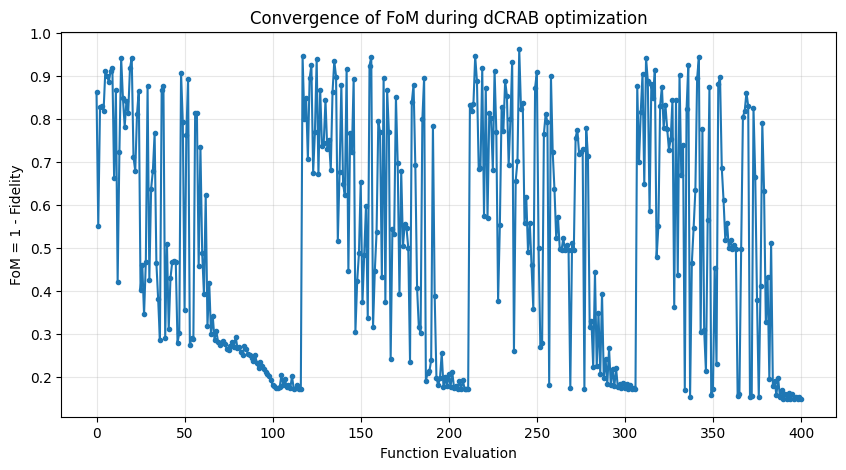

In [8]:
import numpy as np
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence of FoM during dCRAB optimization")
plt.grid(alpha=0.3)
plt.show()


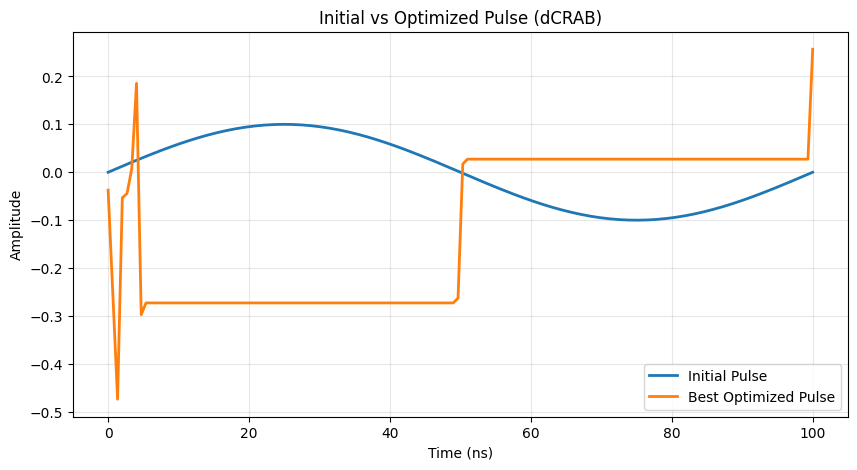

In [9]:
import numpy as np
import matplotlib.pyplot as plt


best_controls = opt_alg.get_best_controls()
best_pulse = np.array(best_controls["pulses"][0])
time_best = np.array(best_controls["timegrids"][0])


T = time_best[-1]
initial_pulse = 0.1 * np.sin(2 * np.pi * time_best / T)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(time_best, initial_pulse, label="Initial Pulse", linewidth=2)
plt.plot(time_best, best_pulse, label="Best Optimized Pulse", linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Initial vs Optimized Pulse (dCRAB)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
